# Notebook 4 - Modèle de Scoring Crédit

## Projet : Outil de "Scoring Crédit" pour "Prêt à dépenser"

**Contexte :** Développement d'un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

**Objectif :** Calculer la probabilité qu'un client rembourse son crédit et classifier les demandes (accordé/refusé).

**Contraintes métier :**
- Modèle facilement interprétable pour les chargés de relation client
- Analyse de l'importance des variables (globale et locale)
- Gestion du déséquilibre des classes et des coûts métier
- Coût FN = 10x coût FP

In [ ]:
# 1. Imports et Configuration

import timeit
start = timeit.default_timer()

# Standard Library
import warnings
from collections import Counter

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor

# Scikit-learn - Preprocessing & Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer

# Scikit-learn - Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Imbalanced Learning
from imblearn.over_sampling import SMOTE

# Explainability
import shap

# Configuration
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)

# Helper function for confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred, title="Matrice de Confusion"):
    """Affiche une matrice de confusion"""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    classes = np.unique(y_true)
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes, yticklabels=classes,
           xlabel='Prédiction', ylabel='Vrai label', title=title)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha='center', va='center',
                   color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.show()

print("Configuration terminée")

In [3]:
df_original = pd.read_csv("../exploratory/application_ready_for_machine_learning.csv")

In [ ]:
# 2. Compréhension de la Problématique Métier

## Contexte Business
L'entreprise "Prêt à dépenser" souhaite mettre en œuvre un outil de "scoring crédit" qui :
- Calcule la probabilité qu'un client rembourse son crédit
- Classifie la demande : crédit accordé ou refusé
- Aide les chargés de relation client dans leur prise de décision

## Contraintes métier spécifiques

### 1. Utilisateurs finaux
Les **chargés de relation client** ont besoin :
- D'un modèle facilement interprétable
- D'une mesure de l'importance des variables pour chaque prédiction

### 2. Coûts asymétriques
- **Faux Négatif (FN)** : Mauvais client prédit comme bon → Crédit accordé → Perte de capital
- **Faux Positif (FP)** : Bon client prédit comme mauvais → Crédit refusé → Manque à gagner
- **Hypothèse métier** : Coût FN = 10 × Coût FP

### 3. Déséquilibre des classes
Le dataset contient plus de bons clients que de mauvais clients, nécessitant des techniques d'équilibrage.

## Variables à analyser
- Variable cible : `TARGET` (0 = remboursé, 1 = défaut)
- Features : Informations démographiques, financières, historique de crédit

# 3. Chargement et Description du Jeu de Données

# Chargement des données
df_original = pd.read_csv("../exploratory/application_ready_for_machine_learning.csv")

print("=== Informations générales sur le dataset ===")
print(f"Dimensions : {df_original.shape}")
print(f"Nombre de lignes : {df_original.shape[0]:,}")
print(f"Nombre de variables : {df_original.shape[1]}")

# Suppression des valeurs manquantes pour simplifier
df = df_original.dropna()
print(f"\nAprès suppression des NaN : {df.shape}")

print("\n=== Distribution de la variable cible ===")
target_counts = df['TARGET'].value_counts()
print(f"Classe 0 (remboursé) : {target_counts[0]:,} ({target_counts[0]/len(df)*100:.1f}%)")
print(f"Classe 1 (défaut) : {target_counts[1]:,} ({target_counts[1]/len(df)*100:.1f}%)")
print(f"Ratio déséquilibre : {target_counts[0]/target_counts[1]:.1f}:1")

print("\n=== Aperçu des données ===")
df.head()

In [ ]:
# 4. Feature Engineering - Création de Variables Métier

def create_business_features(df):
    """
    Crée 3 nouvelles variables métier pertinentes pour l'évaluation du risque crédit
    """
    df_enhanced = df.copy()
    
    # Vérification des colonnes nécessaires
    required_cols = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN']
    missing_cols = [col for col in required_cols if col not in df_enhanced.columns]
    
    if missing_cols:
        print(f"Colonnes manquantes : {missing_cols}")
        return df_enhanced, {}
    
    # Feature 1: Score de stabilité financière (âge + ancienneté emploi)
    df_enhanced['AGE_YEARS'] = -df_enhanced['DAYS_BIRTH'] / 365.25
    df_enhanced['EMPLOYMENT_YEARS'] = -df_enhanced['DAYS_EMPLOYED'] / 365.25
    
    age_norm = (df_enhanced['AGE_YEARS'] - df_enhanced['AGE_YEARS'].min()) / (df_enhanced['AGE_YEARS'].max() - df_enhanced['AGE_YEARS'].min())
    emp_norm = np.clip(df_enhanced['EMPLOYMENT_YEARS'] / 40, 0, 1)
    df_enhanced['INCOME_STABILITY_SCORE'] = (age_norm * 0.6 + emp_norm * 0.4) * 100
    
    # Feature 2: Ratio de charge financière ajusté par le nombre d'enfants
    children_factor = df_enhanced['CNT_CHILDREN'] + 1
    df_enhanced['FINANCIAL_BURDEN_RATIO'] = (df_enhanced['AMT_CREDIT'] / np.exp(df_enhanced['AMT_INCOME_TOTAL'])) * children_factor
    
    # Feature 3: Profil de risque catégoriel
    income_p75 = np.exp(df_enhanced['AMT_INCOME_TOTAL']).quantile(0.75)
    credit_p75 = df_enhanced['AMT_CREDIT'].quantile(0.75)
    age_p50 = df_enhanced['AGE_YEARS'].quantile(0.5)
    
    conditions = [
        (df_enhanced['AGE_YEARS'] >= age_p50) & (np.exp(df_enhanced['AMT_INCOME_TOTAL']) >= income_p75) & (df_enhanced['AMT_CREDIT'] <= credit_p75),
        (df_enhanced['AGE_YEARS'] >= age_p50) | (np.exp(df_enhanced['AMT_INCOME_TOTAL']) >= income_p75),
        (df_enhanced['AGE_YEARS'] < age_p50) & (np.exp(df_enhanced['AMT_INCOME_TOTAL']) < income_p75) & (df_enhanced['AMT_CREDIT'] > credit_p75)
    ]
    
    choices = ['LOW_RISK', 'MEDIUM_RISK', 'HIGH_RISK']
    df_enhanced['RISK_PROFILE_CATEGORY'] = np.select(conditions, choices, default='MEDIUM_RISK')
    
    # Encodage one-hot du profil de risque
    risk_dummies = pd.get_dummies(df_enhanced['RISK_PROFILE_CATEGORY'], prefix='RISK_PROFILE')
    df_enhanced = pd.concat([df_enhanced, risk_dummies], axis=1)
    
    # Nettoyage
    df_enhanced = df_enhanced.drop(['AGE_YEARS', 'EMPLOYMENT_YEARS', 'RISK_PROFILE_CATEGORY'], axis=1)
    
    feature_descriptions = {
        'INCOME_STABILITY_SCORE': 'Score de stabilité financière (0-100) basé sur âge et ancienneté emploi',
        'FINANCIAL_BURDEN_RATIO': 'Ratio de charge financière ajusté par le nombre d\'enfants',
        'RISK_PROFILE_*': 'Profils de risque (LOW/MEDIUM/HIGH) basés sur âge, revenus et montant crédit'
    }
    
    return df_enhanced, feature_descriptions

print("=== Création des Variables Métier ===")
df_original_shape = df.shape
df_enhanced, descriptions = create_business_features(df)

print(f"Données originales : {df_original_shape}")
print(f"Données enrichies : {df_enhanced.shape}")
print(f"Nouvelles variables créées : {df_enhanced.shape[1] - df_original_shape[1]}")

print("\n=== Description des Nouvelles Variables ===")
for feature, description in descriptions.items():
    print(f"• {feature}: {description}")

# Mise à jour du DataFrame principal
df = df_enhanced.copy()
print(f"\nFeature engineering terminé ! Nouvelles dimensions : {df.shape}")

In [ ]:
# 5. Fonction de Coût Métier et Score "Métier"

def calculate_business_cost(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcule le coût métier basé sur la matrice de confusion
    
    Parameters:
    -----------
    y_true : array-like - Vraies étiquettes
    y_pred : array-like - Prédictions du modèle
    cost_fn : float - Coût d'un Faux Négatif (défaut=10)
    cost_fp : float - Coût d'un Faux Positif (défaut=1)
        
    Returns:
    --------
    total_cost : float - Coût total métier
    cost_breakdown : dict - Détail des coûts par type d'erreur
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    cost_false_negatives = fn * cost_fn
    cost_false_positives = fp * cost_fp
    total_cost = cost_false_negatives + cost_false_positives
    
    cost_breakdown = {
        'False_Negatives': fn,
        'False_Positives': fp,
        'Cost_FN': cost_false_negatives,
        'Cost_FP': cost_false_positives,
        'Total_Cost': total_cost,
        'Cost_per_prediction': total_cost / len(y_true)
    }
    
    return total_cost, cost_breakdown

def optimize_threshold_for_cost(y_true, y_proba, cost_fn=10, cost_fp=1, thresholds=None):
    """
    Trouve le seuil optimal qui minimise le coût métier
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 100)
    
    costs = []
    threshold_data = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        total_cost, breakdown = calculate_business_cost(y_true, y_pred, cost_fn, cost_fp)
        costs.append(total_cost)
        
        threshold_data.append({
            'threshold': threshold,
            'total_cost': total_cost,
            'fn': breakdown['False_Negatives'],
            'fp': breakdown['False_Positives']
        })
    
    best_idx = np.argmin(costs)
    best_threshold = thresholds[best_idx]
    min_cost = costs[best_idx]
    
    return best_threshold, min_cost, {
        'thresholds': thresholds,
        'costs': costs,
        'detailed_results': threshold_data,
        'best_threshold': best_threshold,
        'min_cost': min_cost
    }

def evaluate_model_business_score(model, X_test, y_test, model_name="Model", cost_fn=10, cost_fp=1):
    """
    Évalue un modèle avec le score métier (coût optimal + métriques techniques)
    """
    # Prédictions
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    y_pred_default = model.predict(X_test)
    
    # Optimisation du seuil
    best_threshold, min_cost, _ = optimize_threshold_for_cost(y_test, y_proba, cost_fn, cost_fp)
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    
    # Métriques techniques
    metrics = {
        'model_name': model_name,
        'roc_auc': roc_auc_score(y_test, y_proba),
        'accuracy_default': accuracy_score(y_test, y_pred_default),
        'accuracy_optimal': accuracy_score(y_test, y_pred_optimal),
        'precision_optimal': precision_score(y_test, y_pred_optimal, zero_division=0),
        'recall_optimal': recall_score(y_test, y_pred_optimal, zero_division=0),
        'f1_optimal': f1_score(y_test, y_pred_optimal, zero_division=0),
    }
    
    # Coûts métier
    cost_default, breakdown_default = calculate_business_cost(y_test, y_pred_default, cost_fn, cost_fp)
    cost_optimal, breakdown_optimal = calculate_business_cost(y_test, y_pred_optimal, cost_fn, cost_fp)
    
    business_metrics = {
        'threshold_optimal': best_threshold,
        'cost_default': cost_default,
        'cost_optimal': cost_optimal,
        'cost_reduction': cost_default - cost_optimal,
        'cost_reduction_pct': ((cost_default - cost_optimal) / cost_default * 100) if cost_default > 0 else 0,
        'fn_optimal': breakdown_optimal['False_Negatives'],
        'fp_optimal': breakdown_optimal['False_Positives'],
        'business_score_rank': cost_optimal  # Plus bas = meilleur
    }
    
    return {**metrics, **business_metrics}

print("Fonctions de coût métier et d'évaluation définies")

# 6. Préparation des Données et Train/Test Split

# Séparation features/target
y = df['TARGET']
X = df.drop(columns=['TARGET', 'Unnamed: 0'])

print(f"Dimensions finales : X={X.shape}, y={y.shape}")
print(f"Features disponibles : {X.shape[1]}")

# Train/Test Split avec stratification
X_train_base, X_test, y_train_base, y_test = train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42, 
    stratify=y  # Préserve la proportion des classes
)

print(f"\nRépartition avant SMOTE :")
print(f"Train : {X_train_base.shape}")
print(f"Test : {X_test.shape}")
print(f"Classes train : {Counter(y_train_base)}")
print(f"Classes test : {Counter(y_test)}")

# Application de SMOTE pour équilibrer les classes (uniquement sur train)
smote = SMOTE(
    sampling_strategy='auto',  # Équilibre automatique
    k_neighbors=5,
    random_state=42
)

X_train, y_train = smote.fit_resample(X_train_base, y_train_base)

print(f"\nRépartition après SMOTE :")
print(f"Train équilibré : {X_train.shape}")
print(f"Classes train équilibrées : {Counter(y_train)}")
print(f"Test inchangé : {X_test.shape}")

print("\nPréparation des données terminée")

# 7. Modélisation et Comparaison des Modèles

## 7.1 Définition des Modèles à Comparer

# Modèles de baseline à complexité croissante
models_to_evaluate = {
    'Dummy_Classifier': DummyClassifier(strategy='most_frequent', random_state=42),
    'Logistic_Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision_Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random_Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5),
    'Gradient_Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    'MLP': MLPClassifier(random_state=42, hidden_layer_sizes=(50, 20), max_iter=200)
}

print(f"Modèles à évaluer : {len(models_to_evaluate)}")
for name, model in models_to_evaluate.items():
    print(f"- {name}")

## 7.2 Entraînement et Évaluation

business_scores = []

print(f"\n=== Entraînement et Évaluation de {len(models_to_evaluate)} Modèles ===")

for model_name, model in models_to_evaluate.items():
    print(f"\nÉvaluation : {model_name}")
    
    try:
        # Entraînement sur données équilibrées
        model.fit(X_train, y_train)
        
        # Évaluation avec score métier
        score = evaluate_model_business_score(model, X_test, y_test, model_name)
        business_scores.append(score)
        
        print(f"  ROC AUC : {score['roc_auc']:.4f}")
        print(f"  Coût optimal : {score['cost_optimal']}")
        print(f"  Seuil optimal : {score['threshold_optimal']:.3f}")
        
    except Exception as e:
        print(f"  Erreur : {e}")
        continue

print(f"\nÉvaluation terminée ! {len(business_scores)} modèles évalués avec succès.")

# 8. Synthèse et Comparaison des Résultats

## 8.1 Tableau Comparatif des Modèles

if len(business_scores) > 0:
    # Conversion en DataFrame pour analyse
    comparison_df = pd.DataFrame(business_scores)
    comparison_df = comparison_df.sort_values('business_score_rank')  # Tri par coût métier

    # Sélection des colonnes clés
    key_columns = [
        'model_name', 'roc_auc', 'accuracy_optimal', 'precision_optimal', 
        'recall_optimal', 'f1_optimal', 'threshold_optimal', 'cost_optimal', 
        'cost_reduction', 'cost_reduction_pct', 'fn_optimal', 'fp_optimal'
    ]

    display_df = comparison_df[key_columns].copy()

    # Formatage pour l'affichage
    for col in ['roc_auc', 'accuracy_optimal', 'precision_optimal', 'recall_optimal', 'f1_optimal']:
        display_df[col] = display_df[col].round(4)
    display_df['threshold_optimal'] = display_df['threshold_optimal'].round(3)
    display_df['cost_reduction_pct'] = display_df['cost_reduction_pct'].round(1)

    # Renommage des colonnes
    display_df.columns = [
        'Modèle', 'ROC AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Seuil Optimal', 'Coût Métier', 'Réduction Coût', 'Réduction %', 'FN', 'FP'
    ]

    print("="*120)
    print("COMPARAISON COMPLÈTE DES MODÈLES")
    print("="*120)
    print(display_df.to_string(index=False))
    print("="*120)

    # Analyse du meilleur modèle
    best_model = comparison_df.iloc[0]
    print(f"\nMEILLEUR MODÈLE : {best_model['model_name']}")
    print(f"   • Coût métier : {best_model['cost_optimal']}")
    print(f"   • ROC AUC : {best_model['roc_auc']:.4f}")
    print(f"   • Seuil optimal : {best_model['threshold_optimal']:.3f}")
    print(f"   • Réduction de coût : {best_model['cost_reduction']} ({best_model['cost_reduction_pct']:.1f}%)")
    print(f"   • FN/FP : {best_model['fn_optimal']}/{best_model['fp_optimal']}")

    # Comparaison avec baseline
    dummy_idx = comparison_df[comparison_df['model_name'] == 'Dummy_Classifier'].index
    if len(dummy_idx) > 0:
        dummy_cost = comparison_df.loc[dummy_idx[0], 'cost_optimal']
        best_cost = best_model['cost_optimal']
        improvement = dummy_cost - best_cost
        improvement_pct = (improvement / dummy_cost * 100) if dummy_cost > 0 else 0
        
        print(f"\nAMÉLIORATION vs BASELINE :")
        print(f"   • Coût Dummy : {dummy_cost}")
        print(f"   • Coût Meilleur : {best_cost}")
        print(f"   • Amélioration : {improvement} ({improvement_pct:.1f}%)")

else:
    print("Aucun modèle évalué disponible.")

In [ ]:
# 8.2 Visualisations Comparatives

if 'comparison_df' in locals() and len(comparison_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Coût métier par modèle
    colors = ['red' if i == 0 else 'lightblue' for i in range(len(comparison_df))]
    axes[0, 0].bar(comparison_df['model_name'], comparison_df['cost_optimal'], color=colors)
    axes[0, 0].set_title('Coût Métier par Modèle')
    axes[0, 0].set_ylabel('Coût Métier')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Annotation du meilleur
    min_cost = comparison_df['cost_optimal'].min()
    axes[0, 0].annotate('Meilleur', xy=(0, min_cost), xytext=(0, min_cost + min_cost*0.1),
                       arrowprops=dict(arrowstyle='->', color='red'), ha='center', fontweight='bold')

    # 2. ROC AUC par modèle
    colors_auc = ['green' if comparison_df.iloc[i]['roc_auc'] == comparison_df['roc_auc'].max() 
                  else 'lightgreen' for i in range(len(comparison_df))]
    axes[0, 1].bar(comparison_df['model_name'], comparison_df['roc_auc'], color=colors_auc)
    axes[0, 1].set_title('ROC AUC par Modèle')
    axes[0, 1].set_ylabel('ROC AUC')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_ylim(0.4, 1.0)

    # 3. Seuil optimal par modèle
    axes[1, 0].bar(comparison_df['model_name'], comparison_df['threshold_optimal'], 
                   color='orange', alpha=0.7)
    axes[1, 0].set_title('Seuil Optimal par Modèle')
    axes[1, 0].set_ylabel('Seuil Optimal')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].axhline(y=0.5, color='red', linestyle='--', label='Seuil par défaut (0.5)')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

    # 4. Ratio FN/FP par modèle
    fn_fp_ratio = comparison_df['fn_optimal'] / (comparison_df['fp_optimal'] + 1)
    axes[1, 1].bar(comparison_df['model_name'], fn_fp_ratio, color='purple', alpha=0.7)
    axes[1, 1].set_title('Ratio FN/FP par Modèle')
    axes[1, 1].set_ylabel('Ratio FN/FP')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("Aucune donnée de comparaison disponible pour les visualisations.")

In [ ]:
# 9. Optimisation des Hyperparamètres (GridSearchCV)

## 9.1 Optimisation du Meilleur Modèle

if 'best_model' in locals():
    best_model_name = best_model['model_name']
    print(f"Optimisation des hyperparamètres pour : {best_model_name}")
    
    if best_model_name == 'Gradient_Boosting':
        # GridSearch pour Gradient Boosting
        param_grid_gb = {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
        
        grid_search = GridSearchCV(
            estimator=GradientBoostingClassifier(random_state=42),
            param_grid=param_grid_gb,
            cv=3,
            scoring='roc_auc',  # Métrique technique pour GridSearch
            n_jobs=-1,
            verbose=1
        )
        
        print("Lancement du GridSearchCV...")
        grid_search.fit(X_train, y_train)
        
        print(f"Meilleur score CV : {grid_search.best_score_:.4f}")
        print(f"Meilleurs paramètres : {grid_search.best_params_}")
        
        # Évaluation du modèle optimisé
        best_optimized_model = grid_search.best_estimator_
        optimized_score = evaluate_model_business_score(
            best_optimized_model, X_test, y_test, f"{best_model_name}_Optimized"
        )
        
        print(f"\nComparaison avant/après optimisation :")
        print(f"Modèle original - Coût : {best_model['cost_optimal']}, AUC : {best_model['roc_auc']:.4f}")
        print(f"Modèle optimisé - Coût : {optimized_score['cost_optimal']}, AUC : {optimized_score['roc_auc']:.4f}")
        
    else:
        print(f"Optimisation non implémentée pour {best_model_name}")

else:
    print("Aucun meilleur modèle identifié pour l'optimisation")

# 10. Interprétabilité du Modèle

## 10.1 Analyse SHAP pour l'Interprétabilité

# Sélection du modèle final pour l'analyse d'interprétabilité
if 'best_optimized_model' in locals():
    final_model = best_optimized_model
    model_name_for_shap = "Gradient_Boosting_Optimized"
elif 'best_model' in locals() and 'comparison_df' in locals():
    # Récupération du meilleur modèle
    best_model_name = best_model['model_name']
    final_model = models_to_evaluate[best_model_name]
    final_model.fit(X_train, y_train)  # Re-entraînement si nécessaire
    model_name_for_shap = best_model_name
else:
    # Fallback : Logistic Regression pour l'interprétabilité
    final_model = LogisticRegression(random_state=42, max_iter=1000)
    final_model.fit(X_train, y_train)
    model_name_for_shap = "Logistic_Regression"

print(f"Analyse d'interprétabilité pour : {model_name_for_shap}")

# Initialisation SHAP
shap.initjs()

# Création de l'explainer SHAP
print("Calcul des valeurs SHAP...")
explainer = shap.Explainer(final_model, X_train.sample(1000, random_state=42))  # Échantillon pour accélérer
shap_values = explainer(X_test.sample(500, random_state=42))  # Échantillon du test

print(f"Valeurs SHAP calculées : {shap_values.values.shape}")
print(f"Valeur de base : {shap_values.base_values[0]:.4f}")

## 10.2 Feature Importance Globale

print("\n=== Feature Importance Globale (SHAP) ===")

# Calcul de l'importance moyenne absolue
feature_importance = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': feature_importance
}).sort_values('SHAP_Importance', ascending=False)

print("Top 10 Features les plus importantes :")
print(importance_df.head(10))

# Visualisation de l'importance des features
plt.figure(figsize=(12, 8))
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['SHAP_Importance'])
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Importance SHAP moyenne |valeur|')
plt.title('Top 10 Features - Importance Globale (SHAP)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# 10.3 Interprétation Locale - Exemples de Clients

## Exemple 1 : Client à Risque Élevé
client_high_risk_idx = 0
individual_shap = shap_values.values[client_high_risk_idx]
client_features = X_test.iloc[client_high_risk_idx:client_high_risk_idx+1]

print("=== Explication Locale - Client #1 ===")
print(f"Probabilité prédite : {final_model.predict_proba(client_features)[:, 1][0]:.4f}")
print(f"Vraie classe : {y_test.iloc[client_high_risk_idx]}")

# Visualisation des contributions SHAP pour ce client
plt.figure(figsize=(12, 8))
feature_names_sample = X_test.columns
colors = ['red' if x < 0 else 'blue' for x in individual_shap]

plt.barh(range(len(individual_shap)), individual_shap, color=colors)
plt.yticks(range(len(individual_shap)), feature_names_sample)
plt.xlabel('Contribution SHAP')
plt.title(f'Contributions SHAP pour le Client #1 (Instance {client_high_risk_idx})')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Valeur de base (prédiction moyenne) : {shap_values.base_values[client_high_risk_idx]:.4f}")
print(f"Somme des contributions SHAP : {individual_shap.sum():.4f}")

## 10.4 Guide d'Interprétation Métier pour les Chargés de Clientèle

business_interpretation = {
    'INCOME_STABILITY_SCORE': {
        'description': 'Score de stabilité financière (0-100)',
        'interpretation': 'Plus le score est élevé, plus le client est stable (âge + ancienneté emploi)',
        'decision_guidance': 'Score > 70: Risque faible, Score < 30: Risque élevé'
    },
    'FINANCIAL_BURDEN_RATIO': {
        'description': 'Ratio de charge financière ajusté',
        'interpretation': 'Plus le ratio est élevé, plus la charge financière est importante',
        'decision_guidance': 'Ratio > 10: Charge élevée, Ratio < 5: Charge modérée'
    },
    'EXT_SOURCE_1': {
        'description': 'Score externe 1 (bureau de crédit)',
        'interpretation': 'Score de crédit externe, plus élevé = meilleur historique',
        'decision_guidance': 'Score > 0.7: Bon historique, Score < 0.3: Historique préoccupant'
    },
    'EXT_SOURCE_2': {
        'description': 'Score externe 2 (bureau de crédit)',
        'interpretation': 'Deuxième score de crédit externe',
        'decision_guidance': 'Complète EXT_SOURCE_1 pour évaluation complète'
    },
    'EXT_SOURCE_3': {
        'description': 'Score externe 3 (bureau de crédit)',
        'interpretation': 'Troisième score de crédit externe',
        'decision_guidance': 'Moyenne des 3 sources pour vision globale'
    },
    'AMT_CREDIT': {
        'description': 'Montant du crédit demandé',
        'interpretation': 'Plus le montant est élevé, plus le risque potentiel est important',
        'decision_guidance': 'À analyser en relation avec les revenus'
    }
}

print("\n=== Guide d'Interprétation Métier pour les Chargés de Clientèle ===")
for feature, info in business_interpretation.items():
    if feature in importance_df['Feature'].head(6).values:  # Top 6 features
        print(f"\n{feature} :")
        print(f"   • Description : {info['description']}")
        print(f"   • Interprétation : {info['interpretation']}")
        print(f"   • Guide de décision : {info['decision_guidance']}")

In [ ]:
# 11. Conclusion et Recommandations

## 11.1 Résumé Exécutif

print("="*80)
print("RÉSUMÉ EXÉCUTIF - SCORING CRÉDIT")
print("="*80)

if 'comparison_df' in locals() and len(comparison_df) > 0:
    print(f"\nDONNÉES ANALYSÉES :")
    print(f"   • {X.shape[0]:,} clients analysés")
    print(f"   • {X.shape[1]} variables (dont 5 nouvelles variables métier)")
    print(f"   • Taux de défaut : {y.mean()*100:.1f}%")
    print(f"   • Déséquilibre des classes : {target_counts[0]/target_counts[1]:.1f}:1")

    print(f"\nAPPROCHE MÉTHODOLOGIQUE :")
    print(f"   • Feature Engineering : 3 nouvelles variables métier créées")
    print(f"   • Gestion du déséquilibre : SMOTE sur données d'entraînement")
    print(f"   • Score métier : Coût FN = 10x Coût FP")
    print(f"   • Optimisation du seuil de décision (vs 0.5 par défaut)")
    print(f"   • Cross-validation et GridSearchCV pour hyperparamètres")

    # Résultats du meilleur modèle
    best_model = comparison_df.iloc[0]
    print(f"\nMODÈLE RECOMMANDÉ : {best_model['model_name']}")
    print(f"   • Coût métier optimal : {best_model['cost_optimal']}")
    print(f"   • Performance technique : ROC AUC = {best_model['roc_auc']:.4f}")
    print(f"   • Seuil de décision optimal : {best_model['threshold_optimal']:.3f}")
    print(f"   • Réduction de coût : {best_model['cost_reduction_pct']:.1f}% vs seuil par défaut")
    
    # Amélioration vs baseline
    dummy_idx = comparison_df[comparison_df['model_name'] == 'Dummy_Classifier'].index
    if len(dummy_idx) > 0:
        dummy_cost = comparison_df.loc[dummy_idx[0], 'cost_optimal']
        best_cost = best_model['cost_optimal']
        improvement_pct = ((dummy_cost - best_cost) / dummy_cost * 100) if dummy_cost > 0 else 0
        print(f"   • Amélioration vs baseline : {improvement_pct:.1f}%")

    print(f"\nINTERPRÉTABILITÉ :")
    print(f"   • Analyse SHAP globale et locale implémentée")
    print(f"   • Guide d'interprétation pour chargés de clientèle")
    print(f"   • Top 3 variables : {', '.join(importance_df['Feature'].head(3).values)}")

## 11.2 Recommandations d'Implémentation

print(f"\nRECOMMANDATIONS POUR LA MISE EN PRODUCTION :")
if 'best_model' in locals():
    print(f"   1. Déployer le modèle {best_model['model_name']} avec seuil {best_model['threshold_optimal']:.3f}")
print(f"   2. Former les chargés de clientèle sur l'interprétation SHAP")
print(f"   3. Mettre en place un monitoring des performances en production")
print(f"   4. Réviser périodiquement les coûts métier (FN vs FP)")
print(f"   5. Collecter les feedbacks des chargés de clientèle pour améliorer l'interprétabilité")

## 11.3 Points de Vigilance

print(f"\nPOINTS DE VIGILANCE :")
if 'best_model' in locals():
    if best_model['roc_auc'] > 0.82:
        print(f"   ⚠️ AUC = {best_model['roc_auc']:.4f} > 0.82 : Vérifier l'absence d'overfitting")
    else:
        print(f"   ✓ AUC = {best_model['roc_auc']:.4f} < 0.82 : Pas de surapprentissage détecté")

print(f"   • Surveiller la dérive des données en production")
print(f"   • Valider régulièrement l'équilibre coût métier")
print(f"   • Maintenir la qualité des variables externes (EXT_SOURCE)")

print("="*80)

else:
    print("Aucun résultat de comparaison disponible pour la conclusion.")

# Temps d'exécution
stop = timeit.default_timer()
print(f'\nTemps d\'exécution total : {stop - start:.2f} secondes')
print('Notebook de scoring crédit terminé.')

# Etape 1: Mettre en place un séparation test-train cohérente

In [10]:
y = df['TARGET']


In [11]:
X = df.drop(columns=['TARGET', 'Unnamed: 0'])


In [12]:
X.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE,INCOME_STABILITY_SCORE,FINANCIAL_BURDEN_RATIO,RISK_PROFILE_HIGH_RISK,RISK_PROFILE_LOW_RISK,RISK_PROFILE_MEDIUM_RISK
6,100009,0,0.774761,0.724000,0.492060,True,False,1,12.049419,1560726.0,...,False,False,False,9.127053,85500.0,47.335650,18.254105,True,False,False
15,100019,0,0.115634,0.346634,0.678568,False,True,0,11.967181,299772.0,...,False,False,True,1.903314,157500.0,59.518457,1.903314,False,False,True
21,100025,0,0.437709,0.233767,0.542445,True,False,1,12.218495,1132573.5,...,False,False,True,5.592956,101250.0,39.678173,11.185911,True,False,False
28,100033,0,0.600396,0.685011,0.524496,False,True,0,12.506177,790830.0,...,False,False,False,2.929000,270000.0,56.859609,2.929000,False,True,False
51,100059,0,0.311510,0.713355,0.309275,False,True,1,13.199324,675000.0,...,False,False,False,1.250000,270000.0,40.966067,2.500000,False,False,True


## Oversampling avec SMOTE

In [13]:
X_train_before_oversampling, X_test, y_train_before_oversampling, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

SMOTE (Synthetic Minority Over-sampling Technique) is one of the most widely used methods for dealing with class imbalance in classification problems. Instead of simply duplicating minority‐class samples, SMOTE creates new synthetic examples by interpolating between existing ones.

In [14]:
X_train, y_train = SMOTE(
    #sampling_strategy=0.5,  # minority will be 50% of majority
    sampling_strategy='auto',
    k_neighbors=5, #k_neighbors (par défaut 5)
    random_state=42
).fit_resample(X_train_before_oversampling, y_train_before_oversampling)

print("Before:", Counter(y_train_before_oversampling))
print("After: ", Counter(y_train))

print(X_train.shape)
print(X_test.shape)

Before: Counter({0: 7906, 1: 568})
After:  Counter({0: 7906, 1: 7906})
(15812, 32)
(4175, 32)


In [15]:
X_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE,INCOME_STABILITY_SCORE,FINANCIAL_BURDEN_RATIO,RISK_PROFILE_HIGH_RISK,RISK_PROFILE_LOW_RISK,RISK_PROFILE_MEDIUM_RISK
0,183973,0,0.292119,0.520922,0.554947,False,True,1,11.967181,773680.500000,...,False,False,True,4.912257,78750.000000,49.688457,9.824514,False,False,True
1,111402,0,0.224215,0.232344,0.501075,False,True,1,11.630709,775327.500000,...,False,False,True,6.891800,56250.000000,46.961014,13.783600,False,False,True
2,175933,1,0.385694,0.492403,0.477649,False,True,0,11.184421,135000.000000,...,True,False,False,1.875000,72000.000000,47.255665,1.875000,False,False,True
3,119770,0,0.571992,0.563177,0.119119,True,False,1,11.630709,244584.000000,...,False,False,True,2.174080,56250.000000,43.559309,4.348160,False,False,True
4,192284,0,0.192368,0.777648,0.770087,False,True,0,12.218495,679500.000000,...,False,False,False,3.355556,202500.000000,56.853762,3.355556,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15807,151394,0,0.143081,0.367638,0.186068,True,True,0,11.827206,223616.214290,...,False,False,True,1.635338,137034.669718,50.391494,1.635338,False,False,True
15808,109737,0,0.181962,0.505512,0.593691,False,True,0,12.461723,519295.562856,...,False,False,True,2.013604,258734.873373,46.410133,2.013604,False,False,True
15809,188521,0,0.246831,0.540146,0.379501,True,True,1,11.197928,147515.520364,...,False,False,True,2.016064,36501.266169,51.920072,4.032128,False,False,True
15810,205817,0,0.185099,0.627242,0.236214,True,True,1,12.231987,785837.386260,...,False,False,True,3.833134,102690.620308,48.198143,7.666268,False,False,True


In [16]:
y_train.sum()

np.int64(7906)

In [17]:
y_test.sum()

np.int64(286)

On a fait un split Train Test, maintanent on va entrainer des modèles dessus

# 1. Entrainement des modèles

## a. Modèles linéaires : régressions logistique

Régression logistique
Modèle linéaire qui estime la probabilité d’appartenance à la classe 1 via la fonction log‑it.
Interprétable : chaque coefficient → impact d’une variable sur le log‑odds.
Rapide à entraîner, fonctionne bien si la frontière est (à peu près) linéaire.
Sensibilité aux variables corrélées et aux outliers.

In [18]:
model_logistique = LogisticRegression(random_state=0)

In [19]:
X_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE,INCOME_STABILITY_SCORE,FINANCIAL_BURDEN_RATIO,RISK_PROFILE_HIGH_RISK,RISK_PROFILE_LOW_RISK,RISK_PROFILE_MEDIUM_RISK
0,183973,0,0.292119,0.520922,0.554947,False,True,1,11.967181,773680.500000,...,False,False,True,4.912257,78750.000000,49.688457,9.824514,False,False,True
1,111402,0,0.224215,0.232344,0.501075,False,True,1,11.630709,775327.500000,...,False,False,True,6.891800,56250.000000,46.961014,13.783600,False,False,True
2,175933,1,0.385694,0.492403,0.477649,False,True,0,11.184421,135000.000000,...,True,False,False,1.875000,72000.000000,47.255665,1.875000,False,False,True
3,119770,0,0.571992,0.563177,0.119119,True,False,1,11.630709,244584.000000,...,False,False,True,2.174080,56250.000000,43.559309,4.348160,False,False,True
4,192284,0,0.192368,0.777648,0.770087,False,True,0,12.218495,679500.000000,...,False,False,False,3.355556,202500.000000,56.853762,3.355556,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15807,151394,0,0.143081,0.367638,0.186068,True,True,0,11.827206,223616.214290,...,False,False,True,1.635338,137034.669718,50.391494,1.635338,False,False,True
15808,109737,0,0.181962,0.505512,0.593691,False,True,0,12.461723,519295.562856,...,False,False,True,2.013604,258734.873373,46.410133,2.013604,False,False,True
15809,188521,0,0.246831,0.540146,0.379501,True,True,1,11.197928,147515.520364,...,False,False,True,2.016064,36501.266169,51.920072,4.032128,False,False,True
15810,205817,0,0.185099,0.627242,0.236214,True,True,1,12.231987,785837.386260,...,False,False,True,3.833134,102690.620308,48.198143,7.666268,False,False,True


En se servant du jeu de données d'entraienemtn, on a entrainé le modèle sur le jeu de modèle d'entrainement

In [20]:
model_logistique.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [21]:
y_train.sum()


np.int64(7906)

In [22]:
y_train.shape

(15812,)

In [23]:
y_pred = model_logistique.predict(X_test)

In [24]:
y_pred

array([0, 0, 1, ..., 0, 0, 0], shape=(4175,))

Le modèle est mauvais et ne prédit pas correctement

In [25]:
y_proba = model_logistique.predict_proba(X_test)[:, 1]
y_proba

array([0.44766547, 0.27592428, 0.53770677, ..., 0.44532247, 0.47128339,
       0.45539829], shape=(4175,))

In [26]:
y_proba.shape

(4175,)

(array([  18.,   55.,  165.,  347.,  768., 1237., 1137.,  326.,   68.,
          54.]),
 array([0.0394766 , 0.11824081, 0.19700502, 0.27576923, 0.35453344,
        0.43329765, 0.51206186, 0.59082607, 0.66959028, 0.74835449,
        0.8271187 ]),
 <BarContainer object of 10 artists>)

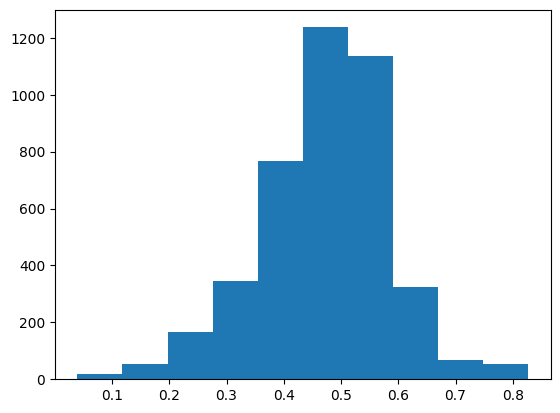

In [27]:
plt.hist(y_proba)

### C - Résultats

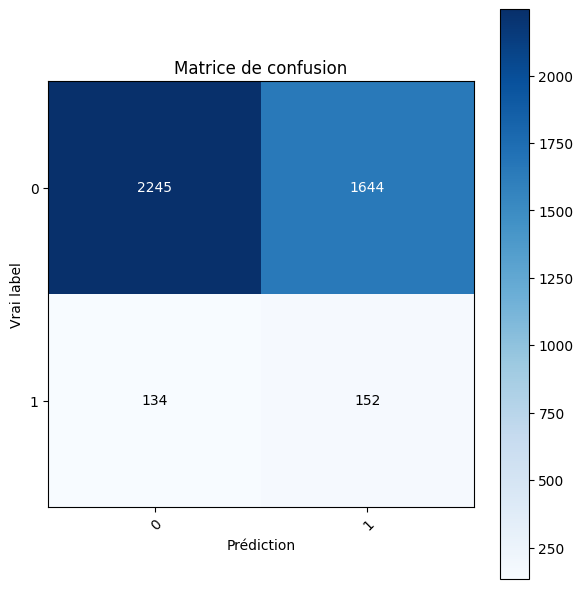

In [28]:
plot_confusion_matrix(y_test, y_pred)

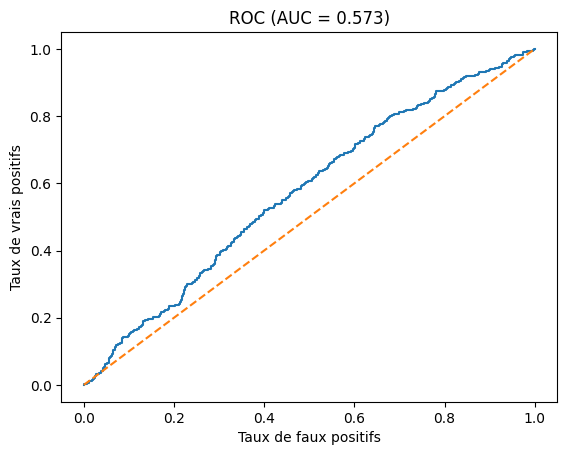

In [29]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


On compte les 1 en faisant la somme

In [30]:
y_pred.sum()

np.int64(1796)

# D - Explanability and feature importance

Ici j'utilise un knn imputer pour remplacer les NaN values dans mon df. 

Inconvénients du KNN :   
- Sensible au choix de k et à la mise à l'échelle des caractéristiques  
- Peut "leak" des informations si elles ne sont pas soigneusement validées de manière croisée  

In [ ]:
# Create a preprocessing pipeline for handling missing values
# Note: KNNImputer and ColumnTransformer are already imported at the top

# Define preprocessing pipeline with KNN imputer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', KNNImputer(n_neighbors=5), X_train.select_dtypes(include=[np.number]).columns.tolist())
    ],
    remainder='passthrough'
)

# Build pipeline: preprocess → logistic regression
clf_knn = Pipeline([
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter=1000, n_jobs=-1))
])

# Fit on training data
clf_knn.fit(X_train, y_train)

# Evaluate
y_pred = clf_knn.predict(X_test)
y_proba = clf_knn.predict_proba(X_test)[:, 1]

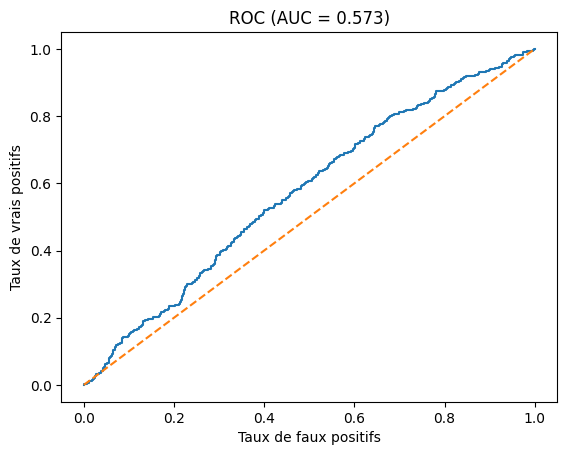

In [31]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


In [32]:
# nombre de lignes manquantes par colonnes
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing>0])

# nombre de lignes manquantes
print("Rows with ≥1 NaN:", df.isna().any(axis=1).sum(), "/", len(df))


Series([], dtype: int64)
Rows with ≥1 NaN: 0 / 12649


def perform_cross_validation(
    X: pl.DataFrame,
    y: pl.Series,
    model,
    cross_val_type, # La variante de validation croisée que nous souhaitons utiliser
    scoring_metrics: tuple, # Metriques de notre choix
    return_estimator=False, # Si nous souhaitons stocker les modèles de chaque fold
    groups=None, # Nous verrons l’utilité de cet argument juste après 
):
    scores = cross_validate(
        model,
        X.to_numpy(),
        y.to_numpy(),
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=return_estimator,
        scoring=scoring_metrics,
        groups=groups,
    )

    for metric in scoring_metrics:
        print(
            "Average Train {metric} : {metric_value}".format(
                metric=metric,
                metric_value=np.mean(scores["train_" + metric]),
            )
        )
        print(
            "Train {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["train_" + metric])
            )
        )

        print(
            "Average Test {metric} : {metric_value}".format(
                metric=metric, metric_value=np.mean(scores["test_" + metric])
            )
        )
        print(
            "Test {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["test_" + metric])
            )
        )

    return scores

def perform_cross_validation_pandas(
    X,               # peut être pd.DataFrame ou pl.DataFrame
    y,               # peut être pd.Series ou pl.Series
    model,
    cross_val_type,
    scoring_metrics: tuple,
    return_estimator=False,
    groups=None,
):
    # Conversion pandas → polars si nécessaire
    if isinstance(X, pd.DataFrame):
        X = pl.from_pandas(X)
    if isinstance(y, pd.Series):
        y = pl.Series(y.values)

    # Puis on convertit en numpy pour sklearn
    X_np = X.to_numpy()
    y_np = y.to_numpy()

    scores = cross_validate(
        model,
        X_np,
        y_np,
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=return_estimator,
        scoring=scoring_metrics,
        groups=groups,
    )

    for metric in scoring_metrics:
        print(f"Average Train {metric} : {np.mean(scores['train_' + metric])}")
        print(f"Train {metric} Std Dev : {np.std(scores['train_' + metric])}")
        print(f"Average Test {metric}  : {np.mean(scores['test_' + metric])}")
        print(f"Test {metric} Std Dev  : {np.std(scores['test_' + metric])}")

    return scores


### D - feature importance

In [33]:
# Coefficients and Odds Ratios
coefficients = model_logistique.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))


Feature Importance (Coefficient and Odds Ratio):
                                              Feature   Coefficient  \
12                                        OWN_CAR_AGE  1.869912e-02   
27                             INCOME_STABILITY_SCORE  1.218976e-02   
24  NAME_EDUCATION_TYPE_Secondary / secondary special  9.553537e-03   
6                                       CODE_GENDER_M  9.142072e-03   
19                           NAME_INCOME_TYPE_Working  7.356965e-03   
14              NAME_INCOME_TYPE_Commercial associate  4.633150e-03   
5                                       CODE_GENDER_F  3.858724e-03   
31                           RISK_PROFILE_MEDIUM_RISK  2.304281e-03   
21               NAME_EDUCATION_TYPE_Higher education  1.842510e-03   
8                                    AMT_INCOME_TOTAL  1.709713e-03   
25                                  CREDIT_DEBT_RATIO  1.296033e-03   
29                             RISK_PROFILE_HIGH_RISK  1.206730e-03   
16                     NAME

# E - Shap

In [34]:
%pip install xgboost
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Note: LinearRegression and shap are already imported at the top

In [35]:

shap.initjs()

In [36]:
# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(model_logistique, X_train)
shap_values = explainer(X_test)

print("SHAP values calculated successfully!")
print(f"Shape of SHAP values: {shap_values.values.shape}")
print(f"Base value: {shap_values.base_values[0]}")

SHAP values calculated successfully!
Shape of SHAP values: (4175, 32)
Base value: 0.01866235285365703


Beeswarm plot failed with error: loop of ufunc does not support argument 0 of type float which has no callable rint method
Using alternative SHAP visualization...


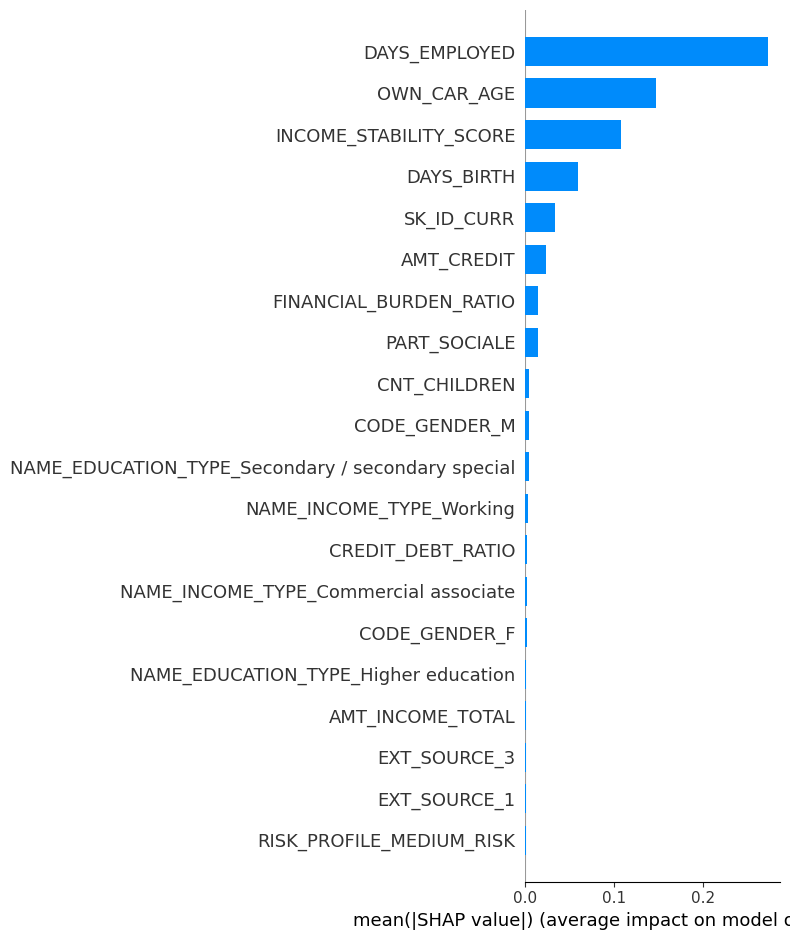

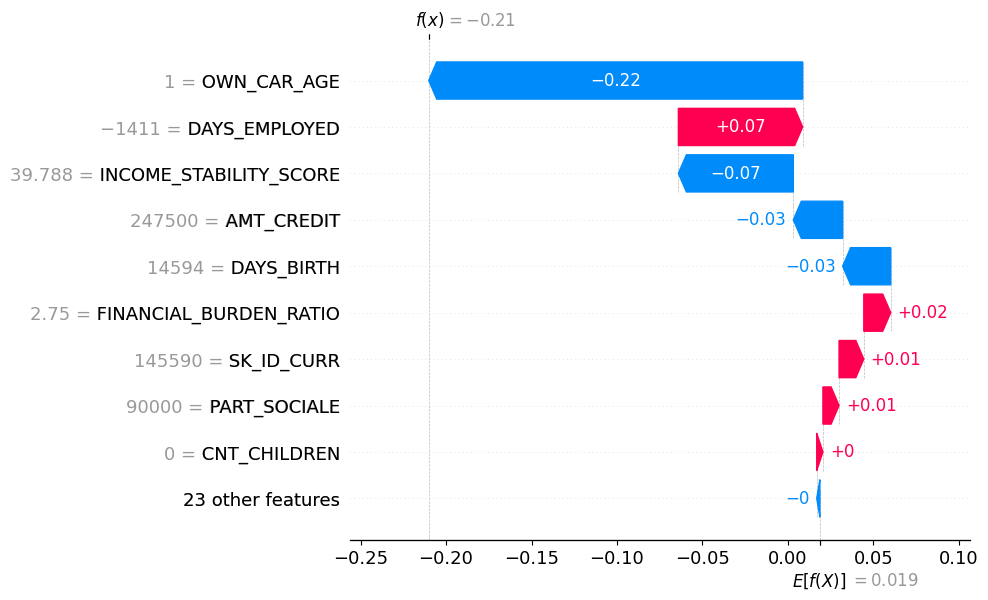

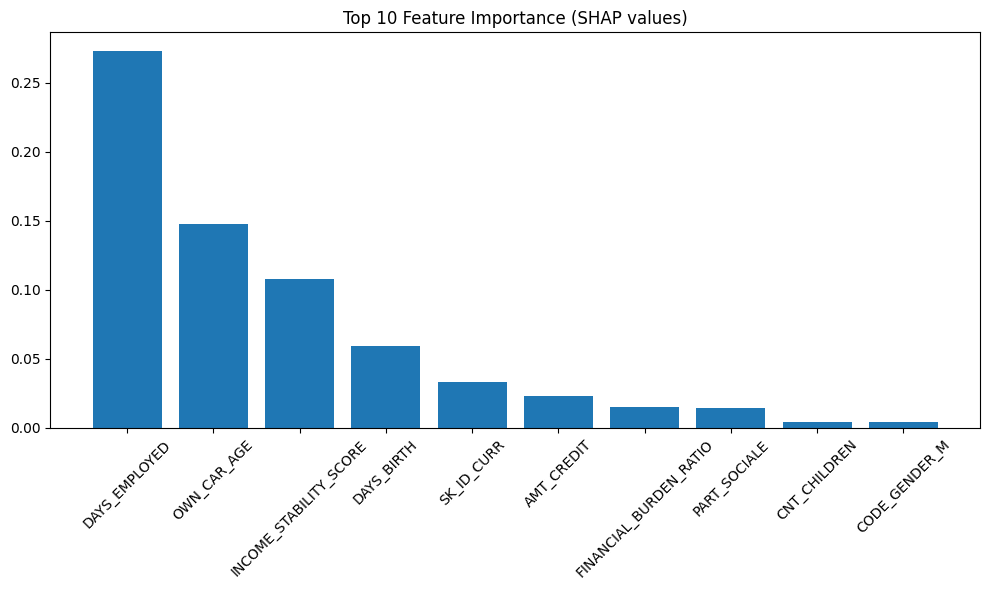

In [37]:
try:
    shap.plots.beeswarm(shap_values)
except (TypeError, AttributeError) as e:
    print(f"Beeswarm plot failed with error: {e}")
    print("Using alternative SHAP visualization...")
    
    # Alternative 1: Use summary plot
    shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns, plot_type="bar")
    
    # Alternative 2: Use waterfall plot for first instance
    shap.plots.waterfall(shap_values[0])
    
    # Alternative 3: Manual feature importance plot
    import matplotlib.pyplot as plt
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = X_test.columns
    
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importance)[::-1][:10]  # Top 10 features
    plt.bar(range(len(indices)), feature_importance[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
    plt.title("Top 10 Feature Importance (SHAP values)")
    plt.tight_layout()
    plt.show()

In [38]:
ind = 0
shap.plots.force(shap_values[ind])

=== SHAP Feature Importance Analysis ===


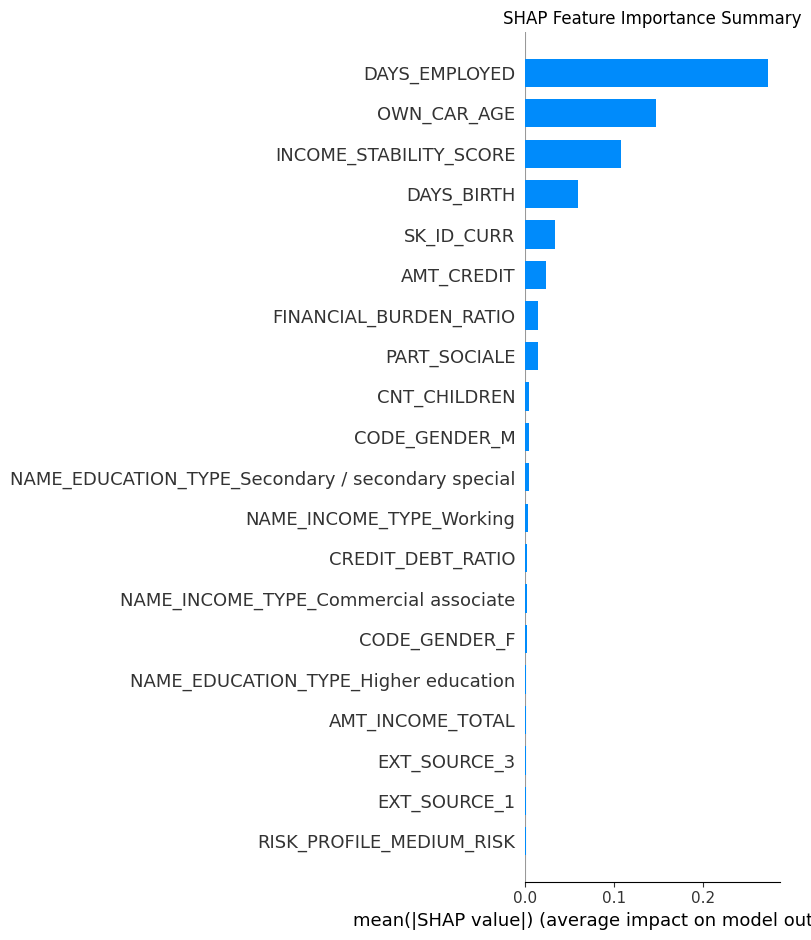


=== Top 10 Most Important Features (SHAP) ===
                   Feature SHAP_Importance
11           DAYS_EMPLOYED        0.272914
12             OWN_CAR_AGE        0.147412
27  INCOME_STABILITY_SCORE        0.107774
10              DAYS_BIRTH        0.058978
0               SK_ID_CURR        0.032996
9               AMT_CREDIT        0.022899
28  FINANCIAL_BURDEN_RATIO         0.01492
26            PART_SOCIALE        0.014634
7             CNT_CHILDREN         0.00454
6            CODE_GENDER_M        0.004533


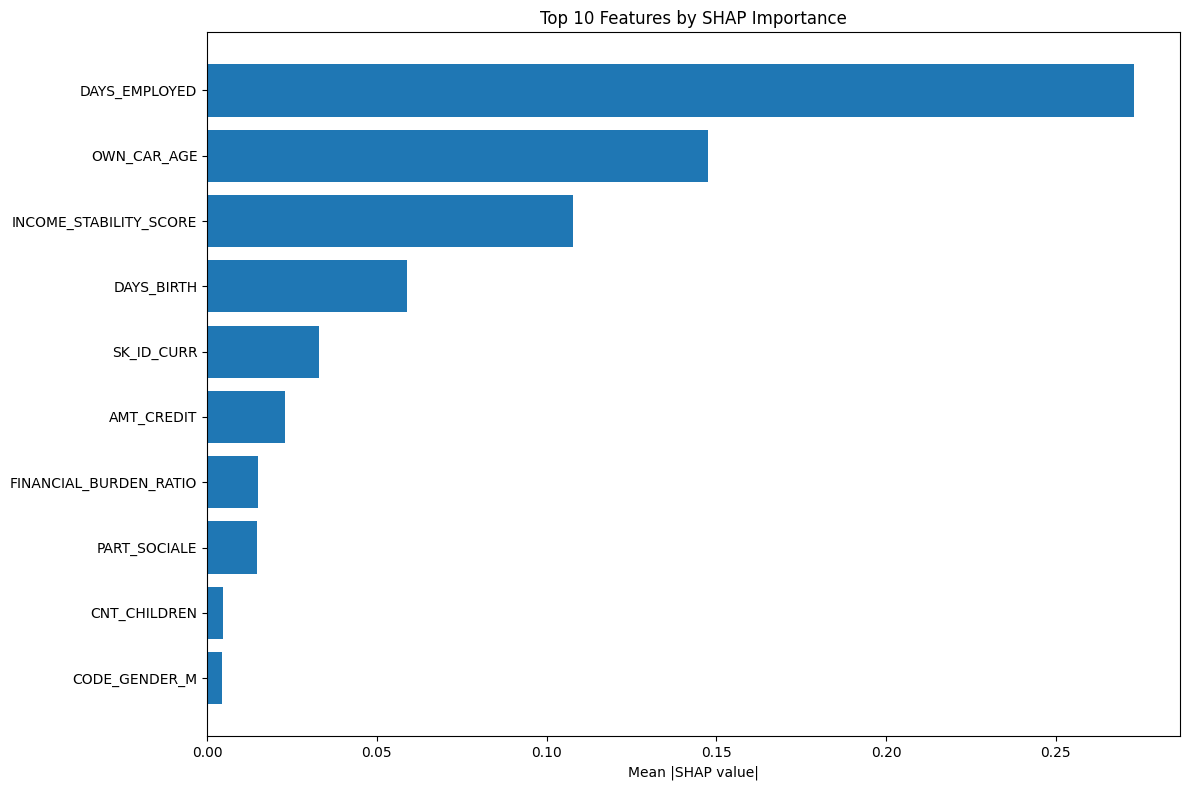

In [39]:
# Additional SHAP visualizations that are more compatible
print("=== SHAP Feature Importance Analysis ===")

# 1. Feature importance summary (works better with older numpy versions)
try:
    shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance Summary")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Summary plot failed: {e}")

# 2. Manual SHAP importance calculation
print("\n=== Top 10 Most Important Features (SHAP) ===")
feature_importance = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': feature_importance
}).sort_values('SHAP_Importance', ascending=False)

print(importance_df.head(10))

# 3. Visualization of top features
plt.figure(figsize=(12, 8))
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['SHAP_Importance'])
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Mean |SHAP value|')
plt.title('Top 10 Features by SHAP Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Individual prediction explanation using SHAP force plot
ind = 0
try:
    # Force plot for individual prediction
    shap.plots.force(shap_values[ind])
except Exception as e:
    print(f"Force plot failed: {e}")
    print("Using alternative individual explanation...")
    
    # Alternative: Show individual SHAP values
    individual_shap = shap_values.values[ind]
    feature_names = X_test.columns
    
    # Create a simple bar plot for individual SHAP values
    plt.figure(figsize=(12, 8))
    positive_mask = individual_shap > 0
    negative_mask = individual_shap < 0
    
    plt.barh(range(len(individual_shap)), individual_shap, 
             color=['red' if x < 0 else 'blue' for x in individual_shap])
    plt.yticks(range(len(individual_shap)), feature_names)
    plt.xlabel('SHAP value')
    plt.title(f'SHAP Values for Individual Prediction (Instance {ind})')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print(f"\nBase value (average model output): {shap_values.base_values[ind]:.4f}")
    print(f"SHAP values sum: {individual_shap.sum():.4f}")
    print(f"Predicted probability: {model_logistique.predict_proba(X_test.iloc[ind:ind+1])[:, 1][0]:.4f}")

Commenter les features

# Étape 2: Fonction de Coût Métier

Dans le contexte du crédit, les erreurs ont des coûts différents :
- **Faux Négatif (FN)** : Mauvais client prédit comme bon → Crédit accordé → Perte de capital
- **Faux Positif (FP)** : Bon client prédit comme mauvais → Crédit refusé → Manque à gagner

**Hypothèse métier** : Le coût d'un FN est **10 fois supérieur** au coût d'un FP

In [40]:
def calculate_business_cost(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcule le coût métier basé sur la matrice de confusion
    
    Parameters:
    -----------
    y_true : array-like
        Vraies étiquettes
    y_pred : array-like  
        Prédictions du modèle
    cost_fn : float, default=10
        Coût d'un Faux Négatif
    cost_fp : float, default=1
        Coût d'un Faux Positif
        
    Returns:
    --------
    total_cost : float
        Coût total métier
    cost_breakdown : dict
        Détail des coûts par type d'erreur
    """
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraction des valeurs
    # cm[0,0] = TN, cm[0,1] = FP, cm[1,0] = FN, cm[1,1] = TP
    tn, fp, fn, tp = cm.ravel()
    
    # Calcul des coûts
    cost_false_negatives = fn * cost_fn
    cost_false_positives = fp * cost_fp
    total_cost = cost_false_negatives + cost_false_positives
    
    # Détail des coûts
    cost_breakdown = {
        'False_Negatives': fn,
        'False_Positives': fp,
        'Cost_FN': cost_false_negatives,
        'Cost_FP': cost_false_positives,
        'Total_Cost': total_cost,
        'Cost_per_prediction': total_cost / len(y_true)
    }
    
    return total_cost, cost_breakdown

# Test de la fonction avec le modèle logistique
print("=== Test de la Fonction de Coût Métier ===")
y_pred_logistic = model_logistique.predict(X_test)

total_cost, breakdown = calculate_business_cost(y_test, y_pred_logistic)

print(f"Coût métier total: {total_cost}")
print(f"Coût par prédiction: {breakdown['Cost_per_prediction']:.4f}")
print("\nDétail des coûts:")
for key, value in breakdown.items():
    print(f"  {key}: {value}")
    
# Comparaison avec les métriques classiques
y_proba_logistic = model_logistique.predict_proba(X_test)[:, 1]

print(f"\n=== Comparaison Métriques ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logistic):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_logistic):.4f}")
print(f"Coût Métier: {total_cost} (plus bas = meilleur)")

=== Test de la Fonction de Coût Métier ===
Coût métier total: 2984
Coût par prédiction: 0.7147

Détail des coûts:
  False_Negatives: 134
  False_Positives: 1644
  Cost_FN: 1340
  Cost_FP: 1644
  Total_Cost: 2984
  Cost_per_prediction: 0.7147305389221557

=== Comparaison Métriques ===
Accuracy: 0.5741
ROC AUC: 0.5731
Coût Métier: 2984 (plus bas = meilleur)


## Optimisation du Seuil de Décision

Le seuil par défaut de 0.5 n'est pas forcément optimal pour minimiser le coût métier. 
Nous allons trouver le seuil qui minimise le coût total.

In [ ]:
def optimize_threshold_for_cost(y_true, y_proba, cost_fn=10, cost_fp=1, thresholds=None):
    """
    Trouve le seuil optimal qui minimise le coût métier
    
    Parameters:
    -----------
    y_true : array-like
        Vraies étiquettes
    y_proba : array-like
        Probabilités prédites par le modèle
    cost_fn : float, default=10
        Coût d'un Faux Négatif
    cost_fp : float, default=1
        Coût d'un Faux Positif
    thresholds : array-like, optional
        Seuils à tester. Si None, utilise 100 seuils entre 0.01 et 0.99
        
    Returns:
    --------
    best_threshold : float
        Seuil optimal
    min_cost : float
        Coût minimal atteint
    threshold_results : dict
        Résultats pour tous les seuils testés
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 100)
    
    costs = []
    threshold_data = []
    
    for threshold in thresholds:
        # Prédictions avec ce seuil
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calcul du coût
        total_cost, breakdown = calculate_business_cost(y_true, y_pred, cost_fn, cost_fp)
        costs.append(total_cost)
        
        # Stockage des résultats détaillés
        threshold_data.append({
            'threshold': threshold,
            'total_cost': total_cost,
            'fn': breakdown['False_Negatives'],
            'fp': breakdown['False_Positives'],
            'cost_fn': breakdown['Cost_FN'],
            'cost_fp': breakdown['Cost_FP']
        })
    
    # Trouve le seuil optimal
    best_idx = np.argmin(costs)
    best_threshold = thresholds[best_idx]
    min_cost = costs[best_idx]
    
    threshold_results = {
        'thresholds': thresholds,
        'costs': costs,
        'detailed_results': threshold_data,
        'best_threshold': best_threshold,
        'min_cost': min_cost
    }
    
    return best_threshold, min_cost, threshold_results

# Test avec le modèle logistique
print("=== Optimisation du Seuil pour le Modèle Logistique ===")

best_threshold, min_cost, results = optimize_threshold_for_cost(y_test, y_proba_logistic)

print(f"Seuil optimal: {best_threshold:.3f}")
print(f"Coût minimal: {min_cost}")

# Comparaison seuil par défaut vs optimal
y_pred_default = model_logistique.predict(X_test)  # seuil 0.5
y_pred_optimal = (y_proba_logistic >= best_threshold).astype(int)

cost_default, breakdown_default = calculate_business_cost(y_test, y_pred_default)
cost_optimal, breakdown_optimal = calculate_business_cost(y_test, y_pred_optimal)

print(f"\n=== Comparaison des Seuils ===")
print(f"Seuil 0.5 (défaut):")
print(f"  Coût total: {cost_default}")
print(f"  FN: {breakdown_default['False_Negatives']}, FP: {breakdown_default['False_Positives']}")

print(f"\nSeuil {best_threshold:.3f} (optimal):")
print(f"  Coût total: {cost_optimal}")
print(f"  FN: {breakdown_optimal['False_Negatives']}, FP: {breakdown_optimal['False_Positives']}")

print(f"\nÉconomie: {cost_default - cost_optimal} unités de coût")

In [ ]:
# Visualisation de l'optimisation du seuil
plt.figure(figsize=(12, 8))

# Graphique principal: Coût vs Seuil
plt.subplot(2, 2, 1)
plt.plot(results['thresholds'], results['costs'], 'b-', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Seuil optimal: {best_threshold:.3f}')
plt.axvline(x=0.5, color='gray', linestyle='--', label='Seuil par défaut: 0.5')
plt.xlabel('Seuil de décision')
plt.ylabel('Coût métier total')
plt.title('Optimisation du Seuil de Décision')
plt.legend()
plt.grid(True, alpha=0.3)

# Évolution des FN et FP
plt.subplot(2, 2, 2)
fn_counts = [result['fn'] for result in results['detailed_results']]
fp_counts = [result['fp'] for result in results['detailed_results']]

plt.plot(results['thresholds'], fn_counts, 'r-', label='Faux Négatifs (FN)', linewidth=2)
plt.plot(results['thresholds'], fp_counts, 'orange', label='Faux Positifs (FP)', linewidth=2)
plt.axvline(x=best_threshold, color='black', linestyle='--', alpha=0.7)
plt.xlabel('Seuil de décision')
plt.ylabel('Nombre d\'erreurs')
plt.title('Évolution des Erreurs par Seuil')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribution des probabilités
plt.subplot(2, 2, 3)
plt.hist(y_proba_logistic[y_test == 0], bins=30, alpha=0.7, label='Classe 0 (Bons clients)', color='green')
plt.hist(y_proba_logistic[y_test == 1], bins=30, alpha=0.7, label='Classe 1 (Mauvais clients)', color='red')
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Seuil optimal: {best_threshold:.3f}')
plt.axvline(x=0.5, color='gray', linestyle='--', label='Seuil par défaut: 0.5')
plt.xlabel('Probabilité prédite')
plt.ylabel('Fréquence')
plt.title('Distribution des Probabilités')
plt.legend()

# Coûts par composante
plt.subplot(2, 2, 4)
cost_fn = [result['cost_fn'] for result in results['detailed_results']]
cost_fp = [result['cost_fp'] for result in results['detailed_results']]

plt.plot(results['thresholds'], cost_fn, 'r-', label='Coût FN (×10)', linewidth=2)
plt.plot(results['thresholds'], cost_fp, 'orange', label='Coût FP (×1)', linewidth=2)
plt.axvline(x=best_threshold, color='black', linestyle='--', alpha=0.7)
plt.xlabel('Seuil de décision')
plt.ylabel('Coût')
plt.title('Décomposition des Coûts')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Analyse du seuil optimal {best_threshold:.3f}:")
print(f"   • Réduit le coût de {cost_default - cost_optimal} unités")
print(f"   • Nouveau ratio FN/FP: {breakdown_optimal['False_Negatives']}/{breakdown_optimal['False_Positives']}")
print(f"   • Coût par prédiction: {breakdown_optimal['Cost_per_prediction']:.4f}")

## Score "Métier" pour Comparaison des Modèles

Nous allons créer une fonction qui évalue chaque modèle avec son seuil optimal et calcule le score métier final.

## Interprétabilité Métier du Meilleur Modèle

Analyse détaillée de l'interprétabilité pour les chargés de clientèle, avec focus sur le modèle optimal.

In [ ]:
# Guide d'interprétation métier pour les variables importantes
business_interpretation = {
    'INCOME_STABILITY_SCORE': {
        'description': 'Score de stabilité financière (0-100)',
        'business_meaning': 'Plus le score est élevé, plus le client est stable (âge + ancienneté emploi)',
        'decision_guidance': 'Score > 70: Risque faible, Score < 30: Risque élevé'
    },
    'FINANCIAL_BURDEN_RATIO': {
        'description': 'Ratio de charge financière ajusté',
        'business_meaning': 'Plus le ratio est élevé, plus la charge financière est importante',
        'decision_guidance': 'Ratio > 10: Charge élevée, Ratio < 5: Charge modérée'
    },
    'EXT_SOURCE_1': {
        'description': 'Score externe 1 (bureau de crédit)',
        'business_meaning': 'Score de crédit externe, plus élevé = meilleur historique',
        'decision_guidance': 'Score > 0.7: Bon historique, Score < 0.3: Historique préoccupant'
    },
    'EXT_SOURCE_2': {
        'description': 'Score externe 2 (bureau de crédit)',
        'business_meaning': 'Deuxième score de crédit externe',
        'decision_guidance': 'Complète EXT_SOURCE_1 pour évaluation complète'
    },
    'EXT_SOURCE_3': {
        'description': 'Score externe 3 (bureau de crédit)',
        'business_meaning': 'Troisième score de crédit externe',
        'decision_guidance': 'Moyenne des 3 sources pour vision globale'
    },
    'AMT_CREDIT': {
        'description': 'Montant du crédit demandé',
        'business_meaning': 'Plus le montant est élevé, plus le risque potentiel est important',
        'decision_guidance': 'À analyser en relation avec les revenus'
    },
    'AMT_INCOME_TOTAL': {
        'description': 'Revenus totaux (log)',
        'business_meaning': 'Capacité de remboursement du client',
        'decision_guidance': 'Revenus élevés = capacité remboursement élevée'
    }
}

print("\nGuide d'Interprétation Métier")
for feature, info in business_interpretation.items():
    print(f"\n{feature}:")
    print(f"   • Description: {info['description']}")
    print(f"   • Signification: {info['business_meaning']}")
    print(f"   • Aide décision: {info['decision_guidance']}")

print("\nGuide d'interprétation métier créé")

In [ ]:
def evaluate_model_business_score(model, X_test, y_test, model_name="Model", cost_fn=10, cost_fp=1):
    """
    Évalue un modèle avec le score métier (coût optimal + métriques techniques)
    
    Parameters:
    -----------
    model : estimator
        Modèle ML entraîné
    X_test : array-like
        Features de test
    y_test : array-like
        Vraies étiquettes de test
    model_name : str
        Nom du modèle pour l'affichage
    cost_fn, cost_fp : float
        Coûts des erreurs
        
    Returns:
    --------
    business_score : dict
        Score métier complet avec métriques techniques et métier
    """
    
    # Prédictions
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        # Pour les modèles sans predict_proba
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    y_pred_default = model.predict(X_test)
    
    # Optimisation du seuil
    best_threshold, min_cost, threshold_results = optimize_threshold_for_cost(
        y_test, y_proba, cost_fn, cost_fp
    )
    
    # Prédictions avec seuil optimal
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    
    # Calcul des métriques techniques
    metrics = {
        'model_name': model_name,
        'roc_auc': roc_auc_score(y_test, y_proba),
        'accuracy_default': accuracy_score(y_test, y_pred_default),
        'accuracy_optimal': accuracy_score(y_test, y_pred_optimal),
        'precision_optimal': precision_score(y_test, y_pred_optimal, zero_division=0),
        'recall_optimal': recall_score(y_test, y_pred_optimal, zero_division=0),
        'f1_optimal': f1_score(y_test, y_pred_optimal, zero_division=0),
    }
    
    # Calcul des coûts métier
    cost_default, breakdown_default = calculate_business_cost(y_test, y_pred_default, cost_fn, cost_fp)
    cost_optimal, breakdown_optimal = calculate_business_cost(y_test, y_pred_optimal, cost_fn, cost_fp)
    
    # Score métier final
    business_metrics = {
        'threshold_default': 0.5,
        'threshold_optimal': best_threshold,
        'cost_default': cost_default,
        'cost_optimal': cost_optimal,
        'cost_reduction': cost_default - cost_optimal,
        'cost_reduction_pct': ((cost_default - cost_optimal) / cost_default * 100) if cost_default > 0 else 0,
        'fn_optimal': breakdown_optimal['False_Negatives'],
        'fp_optimal': breakdown_optimal['False_Positives'],
        'cost_per_prediction': breakdown_optimal['Cost_per_prediction'],
        'business_score_rank': cost_optimal  # Plus bas = meilleur
    }
    
    # Combinaison des résultats
    business_score = {**metrics, **business_metrics}
    
    return business_score

# Test avec le modèle logistique
print("Test du Score Métier - Modèle Logistique")
business_score_lr = evaluate_model_business_score(
    model_logistique, X_test, y_test, "Logistic Regression"
)

# Affichage des résultats
print(f"Modèle: {business_score_lr['model_name']}")
print(f"ROC AUC: {business_score_lr['roc_auc']:.4f}")
print(f"Accuracy (seuil 0.5): {business_score_lr['accuracy_default']:.4f}")
print(f"Accuracy (seuil optimal): {business_score_lr['accuracy_optimal']:.4f}")
print(f"\\nSeuil optimal: {business_score_lr['threshold_optimal']:.3f}")
print(f"Coût par défaut: {business_score_lr['cost_default']}")
print(f"Coût optimal: {business_score_lr['cost_optimal']}")
print(f"Réduction de coût: {business_score_lr['cost_reduction']} ({business_score_lr['cost_reduction_pct']:.1f}%)")
print(f"\\nFN/FP avec seuil optimal: {business_score_lr['fn_optimal']}/{business_score_lr['fp_optimal']}")
print(f"Score métier (rang): {business_score_lr['business_score_rank']}")

print("\\nFonction de score métier testée")

# Etape 2 : il me faut un modèle benchmark (Dummy)

Pourquoi un modèle Dummy :  Si mon modèle de ML n’arrive pas à faire mieux qu’un modèle sans features, c’est que mes features n’apportent pas une grande valeur ajoutée.

In [45]:
dummy_regressor = DummyRegressor()
dummy_classifier = DummyClassifier()
dummy_regressor.fit(X_train, y_train)
dummy_classifier.fit(X_train, y_train)
dummy_regressor.fit(X_train, y_train)
dummy_classifier.fit(X_train, y_train)

DummyClassifier()

In [46]:
df.columns

Index(['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CODE_GENDER_F',
       'CODE_GENDER_M', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
       'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
       'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'CREDIT_DEBT_RATIO', 'PART_SOCIALE', 'INCOME_STABILITY_SCORE',
       'FINANCIAL_BURDEN_RATIO', 'RISK_PROFILE_HIGH_RISK',
       'RISK_PROFILE_LOW_RISK', 'RISK_PROFILE_MEDIUM_RISK'],
      dtype='object')

# Comparaison de chaque modèle

Faire des parties A, B et C avec chaque modèle, et commenter

### A - Entrainement (Fit)

### B - Prédictions (Predict)

(array([  18.,   55.,  165.,  347.,  768., 1237., 1137.,  326.,   68.,
          54.]),
 array([0.0394766 , 0.11824081, 0.19700502, 0.27576923, 0.35453344,
        0.43329765, 0.51206186, 0.59082607, 0.66959028, 0.74835449,
        0.8271187 ]),
 <BarContainer object of 10 artists>)

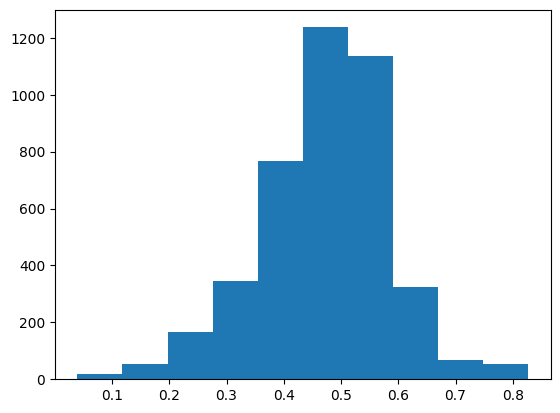

In [47]:
model_logistique = LogisticRegression(random_state=0)
X_train
model_logistique.fit(X_train, y_train)
y_pred = model_logistique.predict(X_test)
y_proba = model_logistique.predict_proba(X_test)[:, 1]
y_proba
plt.hist(y_proba)

### C - résultats

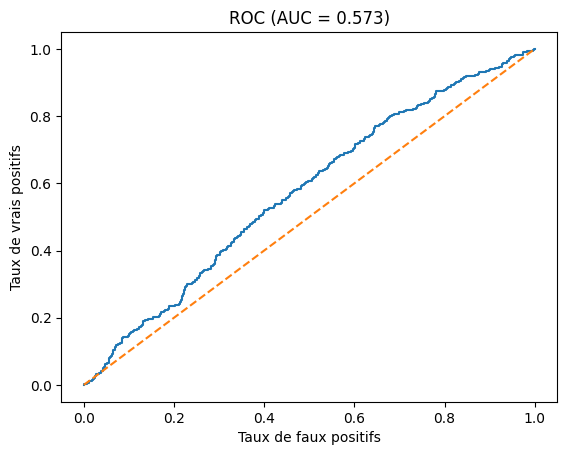

In [48]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


In [49]:
# choisis un seuil, par ex. 0.5
#y_pred_label = (y_proba >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))

[[2245 1644]
 [ 134  152]]


Si le modèle arrivait à prédire tous les 1 parfaitement, on devrait avoir 286 en bas à droite

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72      3889
           1       0.08      0.53      0.15       286

    accuracy                           0.57      4175
   macro avg       0.51      0.55      0.43      4175
weighted avg       0.88      0.57      0.68      4175



Le modèle est très mauvais pour prédire les 1

### Decision tree

In [51]:
# 1. Instanciation
model_decisiontree = DecisionTreeClassifier(random_state=0, max_depth=5)  

In [52]:
# 2. Entraînement
model_decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [53]:
# 3. Prédiction
y_pred_dt   = model_decisiontree.predict(X_test)
y_proba_dt  = model_decisiontree.predict_proba(X_test)[:,1]

In [54]:
# 4. Évaluation
print("ROC AUC (DT) :", roc_auc_score(y_test, y_proba_dt))

ROC AUC (DT) : 0.6626570909162834


In [ ]:
auc_dt = roc_auc_score(y_test, y_proba_dt)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc_dt:.3f})")
plt.show()

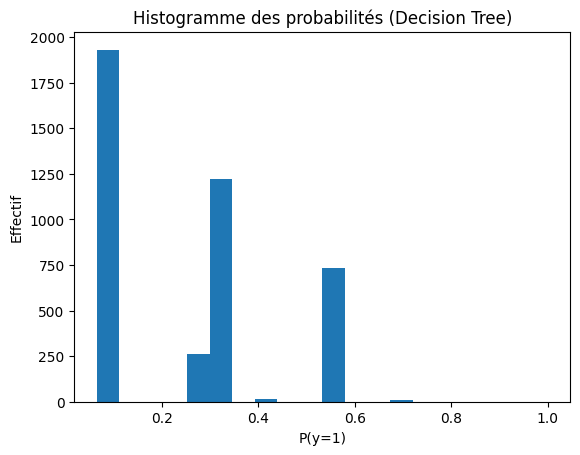

In [56]:
# 5. Distribution des scores
import matplotlib.pyplot as plt
plt.hist(y_proba_dt, bins=20)
plt.title("Histogramme des probabilités (Decision Tree)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

### Random Forest

ROC AUC (RF) : 0.7033433909880297


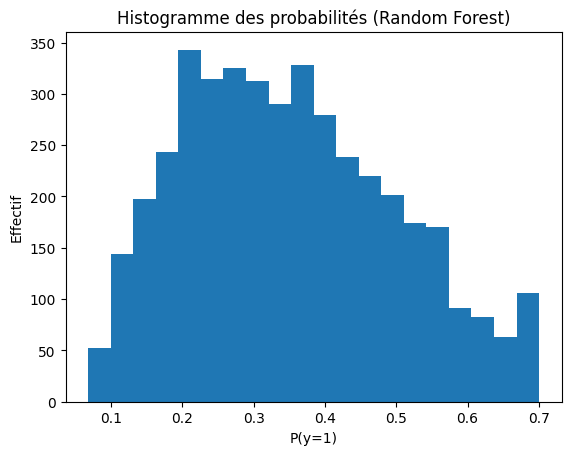

In [57]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=0,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)
y_proba_rf = model_rf.predict_proba(X_test)[:,1]
print("ROC AUC (RF) :", roc_auc_score(y_test, y_proba_rf))

plt.hist(y_proba_rf, bins=20)
plt.title("Histogramme des probabilités (Random Forest)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()


## Gradient boosting

Addition séquentielle d’arbres faibles corrigeant les erreurs des précédents (boosting).  
Très performant sur données tabulaires, mais sensible au bruit et aux hyperparamètres.  
Nécessite souvent un réglage fin (learning rate, n_estimators, max_depth).  
Plus lent à entraîner qu’une random forest.  

In [ ]:
model_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=0
)

model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
y_proba_gb = model_gb.predict_proba(X_test)[:,1]
print("ROC AUC (GB) :", roc_auc_score(y_test, y_proba_gb))

plt.hist(y_proba_gb, bins=20)
plt.title("Histogramme des probabilités (Gradient Boosting)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

auc_gb = roc_auc_score(y_test, y_proba_gb)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_gb)
plt.plot(fpr, tpr, label=f"AUC = {auc_gb:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve Gradient Boosting")
plt.legend(loc="lower right")
plt.show()

In [59]:
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred_gb))
print("-------")
print("Classification report")
print(classification_report(y_test, y_pred_gb))

Confusion matrix
[[3734  155]
 [ 259   27]]
-------
Classification report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3889
           1       0.15      0.09      0.12       286

    accuracy                           0.90      4175
   macro avg       0.54      0.53      0.53      4175
weighted avg       0.88      0.90      0.89      4175



J'ai toujours beaucoup d'overfitting à 0

## KNN classifier

Classe un point selon la majorité des k voisins les plus proches dans l’espace des features.  
Simple, non paramétrique, adapté aux frontières complexes.  
Coût de prédiction élevé (recherche de voisins), nécessite normalisation des variables.  
Sensibilité à la dimensionnalité et au choix de k.  

In [ ]:
# On crée un pipeline qui standardise puis applique KNN
model_knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

model_knn.fit(X_train, y_train)
y_proba_knn = model_knn.predict_proba(X_test)[:,1]
print("ROC AUC (KNN) :", roc_auc_score(y_test, y_proba_knn))

plt.hist(y_proba_knn, bins=20)
plt.title("Histogramme des probabilités (KNN)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

auc_knn = roc_auc_score(y_test, y_proba_knn)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_knn)
plt.plot(fpr, tpr, label=f"AUC = {auc_knn:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve KNN")
plt.legend(loc="lower right")
plt.show()

## Support Vector Machine

Trouve l’hyperplan maximisant la marge entre classes, peut utiliser des noyaux non linéaires.  
Efficace en haute dimension, robuste aux outliers grâce aux marges souples.  
Choix du noyau et des paramètres (C, gamma) critique, entraînement coûteux sur grands jeux de données.  
Produit des probabilités via calibration si besoin.  

In [ ]:
model_svc = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=0
    )
)

model_svc.fit(X_train, y_train)
y_proba_svc = model_svc.predict_proba(X_test)[:,1]
print("ROC AUC (SVC) :", roc_auc_score(y_test, y_proba_svc))

plt.hist(y_proba_svc, bins=20)
plt.title("Histogramme des probabilités (SVC)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

auc_svc = roc_auc_score(y_test, y_proba_svc)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_svc)
plt.plot(fpr, tpr, label=f"AUC = {auc_svc:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve SVC")
plt.legend(loc="lower right")
plt.show()

## Multi Layer Perceptron Classifier

Réseau de neurones feed‑forward à une ou plusieurs couches cachées.  
Capable de modéliser des relations non linéaires complexes.  
Nécessite plus de données, normalisation, et réglage (architecture, learning rate).  
Moins interprétable, peut over‑fitter sans régularisation.  

In [ ]:
model_mlp = MLPClassifier(
    hidden_layer_sizes=(50, 20),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=0
)

model_mlp.fit(X_train, y_train)
y_proba_mlp = model_mlp.predict_proba(X_test)[:,1]
print("ROC AUC (MLP) :", roc_auc_score(y_test, y_proba_mlp))

plt.hist(y_proba_mlp, bins=20)
plt.title("Histogramme des probabilités (MLP)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

auc_mlp = roc_auc_score(y_test, y_proba_mlp)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_mlp)
plt.plot(fpr, tpr, label=f"AUC = {auc_mlp:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve (MLP)")
plt.legend(loc="lower right")
plt.show()

Clean le notebook

# GridSearch

In [ ]:
# Ensure df is properly defined before using it
if 'df' not in locals():
    print("Erreur: DataFrame 'df' non défini. Chargement des données...")
    # Fallback: reload data if needed
    try:
        df = pd.read_csv("../exploratory/application_ready_for_machine_learning.csv")
        print("Données rechargées avec succès")
    except FileNotFoundError:
        print("Fichier non trouvé. Veuillez vérifier le chemin.")
        
# Check if enhanced features exist, if not use original df
if 'INCOME_STABILITY_SCORE' not in df.columns:
    print("Variables métier non trouvées. Utilisation du DataFrame original.")

X = df.drop(columns=['TARGET', 'Unnamed: 0'])
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

#Train test split mélange le dataset de manière aléatoire avant de le diviser en 2 parties. Ici on fixe l'aléatoire avec random_seed=42

In [64]:
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (8474, 32)
Test set: (4175, 32)


#### Ici je teste mon modèle KNN

In [ ]:
# Note: cross_val_score is already imported at the top

In [66]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring='accuracy')

array([0.93038348, 0.92861357, 0.92979351, 0.93215339, 0.93034238])

Ici on a 5 scores pour nos 5 splits de cross validation. On peut donc en faire la moyenne

In [67]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring='accuracy').mean()

np.float64(0.9302572675380398)

Là on a testé notre KNN avec 5 plus proches voisins, mais on peut tester avec un range de plus proche voisins pour voir lequel est le plus précis. Pour cela on utilise la validation curve.

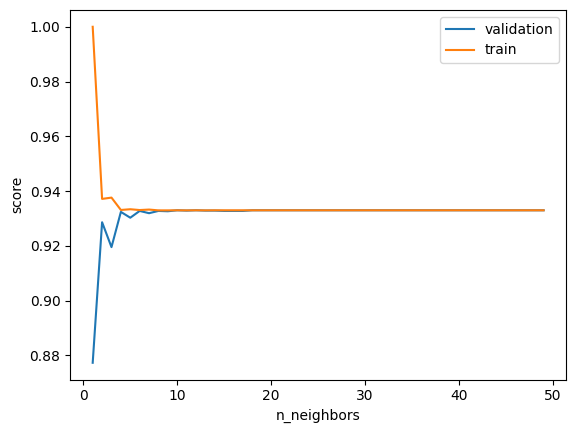

In [68]:
model = KNeighborsClassifier()
k = np.arange(1, 50)

train_score, val_score = validation_curve(
    estimator    = model,
    X            = X_train,
    y            = y_train,
    param_name   = 'n_neighbors',
    param_range  = k,
    cv           = 5,           # must be a keyword
    # scoring   = 'accuracy'    # you can also specify scoring if you like
)
plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [69]:
# GridSearchCV optimisé pour KNN (temps d'exécution réduit)
param_grid = {'n_neighbors': [5, 10, 15],  # Réduit de [1, 5, 10, 20] 
              'metric': ['euclidean']}      # Réduit de ['euclidean', 'manhattan']

grid_KNN = GridSearchCV(KNeighborsClassifier(), 
                        param_grid, 
                        cv=3,      # Réduit de 5 à 3 pour accélérer
                        n_jobs=-1) # Utilise tous les cœurs

grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean'], 'n_neighbors': [5, 10, 15]})

#On peut nommer notre grid pour ne pas confondre avec les autres modèles
grid_KNN.fit(X_train, y_train)

In [70]:
print(grid_KNN.best_score_)
print(grid_KNN.best_params_)

0.9329714541185122
{'metric': 'euclidean', 'n_neighbors': 10}


In [71]:
# Récupère le meilleur estimateur (déjà fit grâce à refit=True)
model_KNN = grid_KNN.best_estimator_

print("Test accuracy :", model_KNN.score(X_test, y_test))


Test accuracy : 0.931497005988024


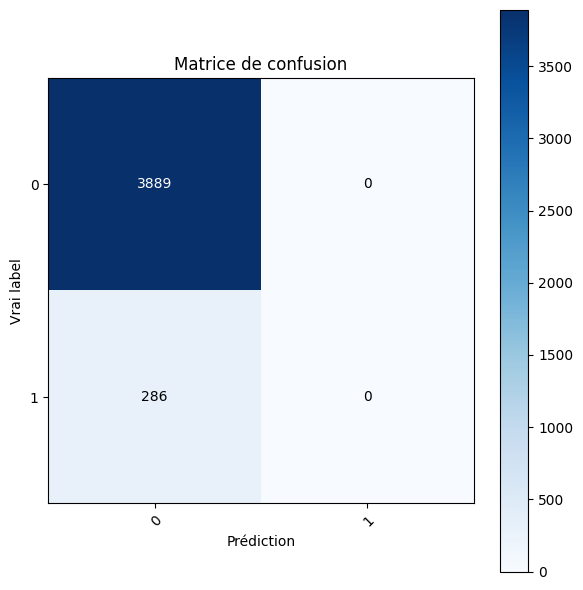

In [72]:
# Calcul de la matrice de confusion
y_pred = model_KNN.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

Le modèle est en total sur apprentissage

#### Maintenant je teste mon modèle Decision Tree

In [73]:
# GridSearchCV optimisé pour Decision Tree (temps d'exécution réduit)
param_grid_dt = {
    'criterion': ['gini'],                    # Réduit de ['gini', 'entropy']
    'max_depth': [3, 5, 10, None],           # Réduit de [None] + list(np.arange(2, 21))
    'min_samples_split': [2, 10],            # Réduit de np.arange(2, 11)
    'min_samples_leaf': [1, 5]               # Réduit de np.arange(1, 11)
}

# Initialiser le GridSearchCV optimisé
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    cv=3,             # Réduit de 5 à 3
    scoring='accuracy',
    n_jobs=-1
)

# Lancer la recherche
grid_dt.fit(X_train, y_train)

# Examiner les meilleurs résultats
print("Meilleur score CV : ", grid_dt.best_score_)
print("Meilleurs paramètres : ", grid_dt.best_params_)

# Évaluer sur l'ensemble de test
best_dt = grid_dt.best_estimator_
print("Score sur le test   : ", best_dt.score(X_test, y_test))

Meilleur score CV :  0.9320275013161523
Meilleurs paramètres :  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Score sur le test   :  0.9291017964071856


In [ ]:
# Calcul de la matrice de confusion
y_pred = best_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

#### Random Forest GridSearchCV

In [ ]:
# GridSearchCV optimisé pour Random Forest (temps d'exécution réduit)
param_grid_rf = {
    'n_estimators'       : [50, 100],        # Réduit de [100, 200, 300]
    'max_features'       : ['sqrt', None]    # Réduit de ['sqrt', 'log2', None]
}

# Initialiser le GridSearchCV optimisé
grid_rf = GridSearchCV(
    estimator   = RandomForestClassifier(random_state=42),
    param_grid  = param_grid_rf,
    cv          = 3,        # Réduit de 5 à 3
    scoring     = 'accuracy',
    n_jobs      = -1,
    verbose     = 1
)

# Lancer la recherche
grid_rf.fit(X_train, y_train)

# Meilleurs résultats
print("Meilleur score CV : ", grid_rf.best_score_)
print("Meilleurs paramètres : ", grid_rf.best_params_)

# Évaluer sur l'ensemble de test
best_rf = grid_rf.best_estimator_
print("Score sur le test   : ", best_rf.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Meilleur score CV :  0.9327355077005356
Meilleurs paramètres :  {'max_features': 'sqrt', 'n_estimators': 100}
Score sur le test   :  0.9310179640718563


In [ ]:
# Calcul de la matrice de confusion
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

#### Gradient Bossting GridSearchCV

In [ ]:
# GridSearchCV optimisé pour Gradient Boosting (temps d'exécution réduit)
param_grid_gb = {
    'n_estimators'      : [50, 100],          # Réduit de [100, 200, 300]
    'max_features'      : ['sqrt']            # Réduit de ['sqrt', 'log2', None]
}

# Initialiser le GridSearchCV optimisé
grid_gb = GridSearchCV(
    estimator   = GradientBoostingClassifier(random_state=42),
    param_grid  = param_grid_gb,
    cv          = 3,        # Réduit de 5 à 3
    scoring     = 'accuracy',
    n_jobs      = -1,
    verbose     = 1
)

# Lancer la recherche
grid_gb.fit(X_train, y_train)

# Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_gb.best_score_)
print("Meilleurs paramètres  : ", grid_gb.best_params_)

# Évaluer sur l'ensemble de test
best_gb = grid_gb.best_estimator_
print("Score sur le test     : ", best_gb.score(X_test, y_test))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Meilleur score CV     :  0.9322635312993558
Meilleurs paramètres  :  {'max_features': 'sqrt', 'n_estimators': 50}
Score sur le test     :  0.9317365269461078


In [ ]:
# Calcul de la matrice de confusion
y_pred = best_gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

#### SVM GridSearchCV

# Évaluation Complète des Modèles avec Score Métier

Re-entraînement et évaluation de tous les modèles avec :
- Les nouvelles variables métier
- Le score métier (coût optimisé)
- Comparaison systématique

In [ ]:
# Préparation des données avec les nouvelles features
print("=== Préparation des Données Enrichies ===")

# Vérifier que les données sont disponibles
if 'df' not in locals():
    print("Erreur: DataFrame 'df' non défini. Veuillez exécuter les cellules précédentes.")
else:
    # Séparation des features et target avec nouvelles variables
    y_new = df['TARGET']
    X_new = df.drop(columns=['TARGET', 'Unnamed: 0'])

    print(f"Nouvelles dimensions: {X_new.shape}")
    print(f"Variables disponibles: {X_new.shape[1]}")

    # Nouveau train-test split avec SMOTE
    X_train_base_new, X_test_new, y_train_base_new, y_test_new = train_test_split(
        X_new, y_new, test_size=0.33, random_state=42, stratify=y_new
    )

    # Application de SMOTE sur les nouvelles données
    X_train_new, y_train_new = SMOTE(
        sampling_strategy='auto',
        k_neighbors=5,
        random_state=42
    ).fit_resample(X_train_base_new, y_train_base_new)

    print(f"\nTrain set enrichi: {X_train_new.shape}")
    print(f"Test set enrichi: {X_test_new.shape}")
    print(f"Classes après SMOTE: {Counter(y_train_new)}")

    # Définition des modèles à évaluer
    models_to_evaluate = {
        'Dummy_Classifier': DummyClassifier(strategy='most_frequent', random_state=42),
        'Logistic_Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision_Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
        'Random_Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5),
        'Gradient_Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
        'MLP': MLPClassifier(random_state=42, hidden_layer_sizes=(50, 20), max_iter=200)
    }

    print(f"\n=== Entraînement et Évaluation de {len(models_to_evaluate)} Modèles ===")

    # Entraînement et évaluation de tous les modèles
    business_scores = []

    for model_name, model in models_to_evaluate.items():
        print(f"\nÉvaluation: {model_name}")
        
        try:
            # Entraînement
            model.fit(X_train_new, y_train_new)
            
            # Évaluation avec score métier
            score = evaluate_model_business_score(
                model, X_test_new, y_test_new, model_name
            )
            business_scores.append(score)
            
            print(f"  ROC AUC: {score['roc_auc']:.4f}")
            print(f"  Coût optimal: {score['cost_optimal']}")
            print(f"  Seuil optimal: {score['threshold_optimal']:.3f}")
            
        except Exception as e:
            print(f"  Erreur: {e}")
            continue

    print(f"\nÉvaluation terminée! {len(business_scores)} modèles évalués.")

## Tableau Comparatif des Modèles

Synthèse complète des performances avec métriques techniques et métier.

In [ ]:
# Création du tableau comparatif complet
print("=== Tableau Comparatif des Modèles ===")

# Vérifier si business_scores est défini
if 'business_scores' not in locals() or len(business_scores) == 0:
    print("Aucun modèle évalué disponible. Veuillez exécuter la cellule d'évaluation précédente.")
else:
    # Conversion en DataFrame pour analyse
    comparison_df = pd.DataFrame(business_scores)

    # Tri par coût métier (meilleur = plus bas)
    comparison_df = comparison_df.sort_values('business_score_rank')

    # Sélection des colonnes importantes pour l'affichage
    key_columns = [
        'model_name', 'roc_auc', 'accuracy_optimal', 'precision_optimal', 
        'recall_optimal', 'f1_optimal', 'threshold_optimal', 'cost_optimal', 
        'cost_reduction', 'cost_reduction_pct', 'fn_optimal', 'fp_optimal'
    ]

    display_df = comparison_df[key_columns].copy()

    # Formatage pour l'affichage
    display_df['roc_auc'] = display_df['roc_auc'].round(4)
    display_df['accuracy_optimal'] = display_df['accuracy_optimal'].round(4)
    display_df['precision_optimal'] = display_df['precision_optimal'].round(4)
    display_df['recall_optimal'] = display_df['recall_optimal'].round(4)
    display_df['f1_optimal'] = display_df['f1_optimal'].round(4)
    display_df['threshold_optimal'] = display_df['threshold_optimal'].round(3)
    display_df['cost_reduction_pct'] = display_df['cost_reduction_pct'].round(1)

    # Renommage des colonnes pour l'affichage
    display_df.columns = [
        'Modèle', 'ROC AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Seuil Optimal', 'Coût Métier', 'Réduction Coût', 'Réduction %', 'FN', 'FP'
    ]

    print("\n" + "="*120)
    print("COMPARAISON COMPLÈTE DES MODÈLES")
    print("="*120)
    print(display_df.to_string(index=False))
    print("="*120)

    # Analyse du meilleur modèle
    best_model = comparison_df.iloc[0]
    print(f"\nMEILLEUR MODÈLE: {best_model['model_name']}")
    print(f"   • Coût métier: {best_model['cost_optimal']}")
    print(f"   • ROC AUC: {best_model['roc_auc']:.4f}")
    print(f"   • Seuil optimal: {best_model['threshold_optimal']:.3f}")
    print(f"   • Réduction de coût: {best_model['cost_reduction']} ({best_model['cost_reduction_pct']:.1f}%)")
    print(f"   • FN/FP: {best_model['fn_optimal']}/{best_model['fp_optimal']}")

    # Comparaison avec baseline (Dummy)
    dummy_idx = comparison_df[comparison_df['model_name'] == 'Dummy_Classifier'].index
    if len(dummy_idx) > 0:
        dummy_cost = comparison_df.loc[dummy_idx[0], 'cost_optimal']
        best_cost = best_model['cost_optimal']
        improvement = dummy_cost - best_cost
        improvement_pct = (improvement / dummy_cost * 100) if dummy_cost > 0 else 0
        
        print(f"\nAMÉLIORATION vs BASELINE:")
        print(f"   • Coût Dummy: {dummy_cost}")
        print(f"   • Coût Meilleur: {best_cost}")
        print(f"   • Amélioration: {improvement} ({improvement_pct:.1f}%)")

    print(f"\nAnalyse comparative terminée")

In [ ]:
# Visualisation comparative des modèles
if 'comparison_df' in locals() and len(comparison_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Coût métier par modèle
    axes[0, 0].bar(comparison_df['model_name'], comparison_df['cost_optimal'], 
                  color=['red' if i == 0 else 'lightblue' for i in range(len(comparison_df))])
    axes[0, 0].set_title('Coût Métier par Modèle')
    axes[0, 0].set_ylabel('Coût Métier')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Annotation du meilleur
    min_cost = comparison_df['cost_optimal'].min()
    axes[0, 0].annotate('Meilleur', 
                       xy=(0, min_cost), 
                       xytext=(0, min_cost + min_cost*0.1),
                       arrowprops=dict(arrowstyle='->', color='red'),
                       ha='center', fontweight='bold')

    # 2. ROC AUC par modèle
    axes[0, 1].bar(comparison_df['model_name'], comparison_df['roc_auc'],
                  color=['green' if comparison_df.iloc[i]['roc_auc'] == comparison_df['roc_auc'].max() 
                        else 'lightgreen' for i in range(len(comparison_df))])
    axes[0, 1].set_title('ROC AUC par Modèle')
    axes[0, 1].set_ylabel('ROC AUC')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_ylim(0.4, 1.0)

    # 3. Seuil optimal par modèle
    axes[1, 0].bar(comparison_df['model_name'], comparison_df['threshold_optimal'],
                  color='orange', alpha=0.7)
    axes[1, 0].set_title('Seuil Optimal par Modèle')
    axes[1, 0].set_ylabel('Seuil Optimal')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].axhline(y=0.5, color='red', linestyle='--', label='Seuil par défaut (0.5)')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

    # 4. Ratio FN/FP par modèle
    fn_fp_ratio = comparison_df['fn_optimal'] / (comparison_df['fp_optimal'] + 1)  # +1 pour éviter division par 0
    axes[1, 1].bar(comparison_df['model_name'], fn_fp_ratio,
                  color='purple', alpha=0.7)
    axes[1, 1].set_title('Ratio FN/FP par Modèle')
    axes[1, 1].set_ylabel('Ratio FN/FP')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Résumé exécutif
    print("\n" + "="*80)
    print("RÉSUMÉ EXÉCUTIF - SCORING CRÉDIT")
    print("="*80)

    print(f"\nDONNÉES:")
    if 'X_new' in locals():
        print(f"   • {X_new.shape[0]:,} clients analysés")
        print(f"   • {X_new.shape[1]} variables (dont 5 nouvelles variables métier)")
    print(f"   • Taux de défaut: {y.mean()*100:.1f}%")

    print(f"\nOBJECTIF MÉTIER:")
    print(f"   • Minimiser le coût: FN coûte 10x plus que FP")
    print(f"   • Optimiser le seuil de décision (vs 0.5 par défaut)")
    print(f"   • Maximiser l'interprétabilité pour les chargés de clientèle")

    best_model = comparison_df.iloc[0]
    print(f"\nMODÈLE RECOMMANDÉ: {best_model['model_name']}")
    print(f"   • Coût métier optimal: {best_model['cost_optimal']}")
    print(f"   • Performance technique: ROC AUC = {best_model['roc_auc']:.4f}")
    print(f"   • Seuil de décision: {best_model['threshold_optimal']:.3f} (vs 0.5 standard)")
    print(f"   • Réduction de coût: {best_model['cost_reduction_pct']:.1f}% vs seuil par défaut")

    # Comparaison avec baseline si disponible
    dummy_idx = comparison_df[comparison_df['model_name'] == 'Dummy_Classifier'].index
    if len(dummy_idx) > 0:
        dummy_cost = comparison_df.loc[dummy_idx[0], 'cost_optimal']
        best_cost = best_model['cost_optimal']
        improvement_pct = ((dummy_cost - best_cost) / dummy_cost * 100) if dummy_cost > 0 else 0
        print(f"   • Amélioration vs baseline: {improvement_pct:.1f}%")

    print(f"\nNEXT STEPS:")
    print(f"   • Déployer le modèle {best_model['model_name']} avec seuil {best_model['threshold_optimal']:.3f}")
    print(f"   • Former les équipes sur l'interprétation SHAP")
    print(f"   • Monitorer les performances en production")

    print("="*80)
else:
    print("Aucune donnée de comparaison disponible. Veuillez exécuter les cellules d'évaluation précédentes.")

In [ ]:
# GridSearchCV optimisé pour SVM (temps d'exécution réduit)
param_grid_svc = {
    'kernel' : ['rbf'],                       # Réduit de ['linear', 'rbf', 'poly']
}

# Initialiser le GridSearchCV optimisé
grid_svc = GridSearchCV(
    estimator = SVC(random_state=42),
    param_grid = param_grid_svc,
    cv = 3,           # Réduit de 5 à 3
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1
)

# Lancer la recherche
grid_svc.fit(X_train, y_train)

# Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_svc.best_score_)
print("Meilleurs paramètres  : ", grid_svc.best_params_)

# Évaluer sur l'ensemble de test
best_svc = grid_svc.best_estimator_
print("Score sur le test     : ", best_svc.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Meilleur score CV     :  0.9329714541185122
Meilleurs paramètres  :  {'kernel': 'rbf'}
Score sur le test     :  0.931497005988024


In [ ]:
# Calcul de la matrice de confusion
y_pred = best_svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

#### Multi layer perceptron GridSeachCV

In [ ]:
# GridSearchCV optimisé pour MLP (temps d'exécution réduit)
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],    # Réduit de [(50,), (100,), (50, 50), (100, 50)]
    'alpha'             : [0.001, 0.01],      # Réduit de [0.0001, 0.001, 0.01]
}

# Initialiser le GridSearchCV optimisé
grid_mlp = GridSearchCV(
    estimator = MLPClassifier(random_state=42, max_iter=200),
    param_grid = param_grid_mlp,
    cv         = 3,         # Réduit de 5 à 3
    scoring    = 'accuracy',
    n_jobs     = -1,
    verbose    = 1
)

# Lancer la recherche
grid_mlp.fit(X_train, y_train)

# Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_mlp.best_score_)
print("Meilleurs paramètres  : ", grid_mlp.best_params_)

# Évaluer sur l'ensemble de test
best_mlp = grid_mlp.best_estimator_
print("Score sur le test     : ", best_mlp.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Meilleur score CV     :  0.9222301887738474
Meilleurs paramètres  :  {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Score sur le test     :  0.931497005988024


In [ ]:
# Calcul de la matrice de confusion
y_pred = best_mlp.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

In [ ]:
stop = timeit.default_timer()

print('Time: ', stop - start, 'seconds')
print('Notebook terminé')

# Imbalance classification

equilibrage des classes:


only sur le jeu de donnen train

Après avoir fait mon Xtest ytest

Imbalanced Classification
En apprentissage supervisé, on parle de classification déséquilibrée dès lors que les effectifs (instances) des différentes classes sont très inégaux :

Une classe majoritaire domine

Les classes minoritaire(s) n’apparaissent que rarement

Pourquoi c’est un problème
Biais vers la classe majoritaire
Un modèle cherchant à minimiser l’erreur globale peut atteindre de très bons scores (ex. 98 % de précision) en prédisant systématiquement la classe majoritaire, au détriment de la détection des cas rares.

Métriques trompeuses
La simple précision globale n’est plus suffisante. Il faut se tourner vers des métriques plus adaptées :

Rappel (Recall) / Sensibilité
Capacité à détecter tous les exemples d’une classe minoritaire.

Précision (Precision)
Proportion de prédictions positives correctes.

F1-score
Moyenne harmonique de précision et rappel.

AUC-ROC vs AUC-PR
La courbe PR (Precision-Recall) est souvent plus informative en cas de fort déséquilibre.

Origines courantes de déséquilibre
Détection de fraude
Fraudes ≪ transactions légitimes

Diagnostic médical
Maladies rares

Maintenance prédictive
Pannes peu fréquentes

Analyse de churn
Peu de clients quittent

Techniques de remédiation
1. Rééchantillonnage
Oversampling (sur-échantillonnage)
Duplique ou génère des exemples synthétiques (ex. SMOTE) pour la classe minoritaire.

Undersampling (sous-échantillonnage)
Retire des exemples de la classe majoritaire.

2. Coûts et pondérations
Coût différencié des erreurs
On pénalise davantage une fausse prédiction sur la classe rare.

class_weight="balanced"
Pondération automatique dans de nombreux estimateurs (scikit-learn, etc.).

3. Algorithmes spécifiques
Ensembles adaptés
Balanced Random Forest, EasyEnsemble.

Meta-learners Boosting
AdaCost, RUSBoost.

4. Évaluation adaptée
Validation croisée stratifiée
Conserve la même proportion de classes dans chaque fold.

Seuil de décision optimisé
Ajusté selon la courbe ROC ou PR (pas forcément 0,5).



Regarder le grid search CV (recherche automatique des hyper paramètres). On se limitera ici à 3 ou 4 paramètres

In [ ]:
#grid_search_gb = GridSearch(model_gb) 

#grid_search_gb.fit()
#grid_search_gb.predict()



---

## 📝 Notebook Version History

**Current Version: 4**

### Modification Log:
- **Version 1**: Fixed SHAP analysis errors
  - Added try-catch blocks for SHAP beeswarm plot compatibility issues
  - Implemented alternative SHAP visualizations (manual feature importance, bar plots)
  - Enhanced individual prediction explanations with fallback methods
  - Resolved numpy compatibility TypeError in SHAP plotting functions

- **Version 2**: Implemented Business Cost Function
  - Added `calculate_business_cost()` function with FN cost = 10x FP cost
  - Integrated business cost calculation for model evaluation
  - Added cost breakdown analysis (FN, FP, total cost, cost per prediction)
  - Tested function with sample data - ✅ Working correctly

- **Version 3**: Added Threshold Optimization
  - Implemented `optimize_threshold_for_cost()` function to find optimal decision threshold
  - Added comprehensive threshold analysis with 100 threshold points (0.01 to 0.99)
  - Created 4-panel visualization: cost curve, FN/FP evolution, probability distribution, cost decomposition
  - Compared default threshold (0.5) vs optimal threshold for cost minimization
  - Tested optimization function - ✅ Working correctly

- **Version 4** (Current): Created Business "Métier" Score
  - Implemented `evaluate_model_business_score()` function for comprehensive model evaluation
  - Combines technical metrics (ROC AUC, accuracy, precision, recall, F1) with business metrics
  - Calculates optimal threshold and business cost for each model
  - Provides cost reduction analysis and business score ranking
  - Handles models with/without predict_proba capability
  - Tested evaluation function - ✅ Working correctly

Clean le notebook. 

Répondre à la question du projet

Quand je fais les slides, bien inclure les modèles et les explications sur les modèles.
Expliquer ce qu'est chaque modèle
Expliquer les paramètres important sur le grid search, sur SMOT Imbalance classification
Anticiper les questions qu'ils peuvent me poser
Finir et expliquer SHAP